All machine learning models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (make_scorer, recall_score, confusion_matrix,
                             ConfusionMatrixDisplay, accuracy_score,
                             roc_curve, auc, classification_report, f1_score)

# Logistic Regression Model
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

#LDA Model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

# Torch model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Fixed seed
np.random.seed(42)

# Binary

Our dataset has 3 classes:


1.   0 for Healthy
2.   1 for Pre Diabetes
3.   2 for Typ 2 Diabetes

We decided to train Binary models in this section to difference between Typ 2 Diabetes and Healthy. In the other section we train multiclass models.


In [2]:
# Preparing Test dataset
data = pd.read_csv('/content/diabetes_012_health_indicators_BRFSS2015.csv')


# -------- Dataset for Binary Model  --------

# Dropping Pre Diabetes
data = data[data['Diabetes_012'] != 1]
data['Diabetes_012'] = data['Diabetes_012'].replace({2: 1}) #rename

# X,y
X = data.drop('Diabetes_012', axis=1)
y = data['Diabetes_012']


# stratify=y ensures that the distribution of the different label is the same in test/train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.04, random_state=42,stratify=y)

X_train["has_diabetes"] = y_train
X_test["has_diabetes"] = y_test

print(f'BINARY: Training data shape: {X_train.shape}')
print(f'BINARY: Test data shape: {X_test.shape}')

X_train.to_csv('train_binary.csv', index=False)
X_test.to_csv('test_binary.csv', index=False)

# -------- Dataset for Multi Class Model  --------

# Dropping Pre Diabetes
data = pd.read_csv('/content/diabetes_012_health_indicators_BRFSS2015.csv')
# X,y
X = data.drop('Diabetes_012', axis=1)
y = data['Diabetes_012']


# stratify=y ensures that the distribution of the different label is the same in test/train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.04, random_state=42,stratify=y)

X_train["diabetes_type"] = y_train
X_test["diabetes_type"] = y_test

print(f'Multi-Class: Training data shape: {X_train.shape}')
print(f'Multi-Class Test data shape: {X_test.shape}')

X_train.to_csv('train_multiclass.csv', index=False)
X_test.to_csv('test_multiclass.csv', index=False)

<ipython-input-2-67e1f9e85814>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Diabetes_012'] = data['Diabetes_012'].replace({2: 1}) #rename


BINARY: Training data shape: (239087, 22)
BINARY: Test data shape: (9962, 22)
Multi-Class: Training data shape: (243532, 22)
Multi-Class Test data shape: (10148, 22)


## Logistic Regression

### Pre Processing

Using Downsampling to the lower class 1 to balance the dataset.

In [3]:
train = pd.read_csv('/content/train_binary.csv')
test = pd.read_csv('/content/test_binary.csv')
'''
DOWN SAMPLING: balancing the dataset and deleting some false as currently the dataset is distributed:
0      205155
1      33932

balancing to

0     33932
1     33932

'''

#Balancing for no diabetes, label 0
rows_with_value_0 = train[train['has_diabetes'] == 0]
# Randomly sample 209203 rows from the filtered rows
rows_to_delete = rows_with_value_0.sample(n=171223)
# Drop the selected rows from the original DataFrame
train.drop(rows_to_delete.index, inplace=True)

print("Balanced data: Label 0:",np.sum(train['has_diabetes'] == 0),"Label 1:", np.sum(train['has_diabetes'] == 1))


# Create a DataFrame of X_train and y_train
train_log = train.copy()
test_log = test.copy()



# Shapes
print(f'Training data shape without Prediabetes: {train_log.shape}')
print(f'Test data shape without Prediabetes: {test_log.shape}')


Balanced data: Label 0: 33932 Label 1: 33932
Training data shape without Prediabetes: (67864, 22)
Test data shape without Prediabetes: (9962, 22)


Binary Baseline Model

In [4]:
# How many have diabetes in the training set?

diabetes_false = np.sum(train_log["has_diabetes"] == 0)  # no diabetes
diabetes_true = np.sum(train_log["has_diabetes"] == 1)   # diabetes
print(pd.Series({'0': diabetes_false, '1': diabetes_true}))

0    33932
1    33932
dtype: int64


In [5]:
#train Baselinemodel
baselinemodel = 0
acc_base_train= diabetes_false/(diabetes_false + diabetes_true)
print("Accuracy of the baselinemodel (only considering two classes) on training data:", acc_base_train)
acc_base_test = np.sum(y_test == 0) / (np.sum(y_test == 0)+np.sum(y_test == 1))
print("Accuracy of the baselinemodel (only considering two classes) on test data:", acc_base_test)

Accuracy of the baselinemodel (only considering two classes) on training data: 0.5
Accuracy of the baselinemodel (only considering two classes) on test data: 0.9788184108083352


Logistic Regression (VIF+ Feature Selection, Calculate FPR/TPR/ROC/Acc/Confusion Matrix)

In [ ]:
#VIF Analysis in order to determine which variables to take into account

def VIF(df, columns):
    values = sm.add_constant(df[columns]).values
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    return pd.Series(vif[1:], index=columns)
# Features
cols = ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income']

VIF(X_train, cols)

,0
HighBP,1.330910
HighChol,1.173236
CholCheck,1.032906
BMI,1.140030
Smoker,1.092225
Stroke,1.081573
HeartDiseaseorAttack,1.171891
PhysActivity,1.157802
Fruits,1.112462
Veggies,1.112291


All VIF values are less than 5 (around 1) so we can take all features into account.

### Training

Evaluating which columns lead to a high p-value

In [ ]:
import statsmodels.formula.api as smf
logreg1 = smf.logit(formula = """has_diabetes ~ HighBP + HighChol + CholCheck
+ BMI + Smoker + Stroke + HeartDiseaseorAttack + PhysActivity + Fruits
+ Veggies + HvyAlcoholConsump + AnyHealthcare + NoDocbcCost + GenHlth + MentHlth
+ PhysHlth + DiffWalk + Sex + Age + Education + Income""", data = train_log).fit()
print(logreg1.summary())



Optimization terminated successfully.
         Current function value: 0.508836
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           has_diabetes   No. Observations:                67864
Model:                          Logit   Df Residuals:                    67842
Method:                           MLE   Df Model:                           21
Date:                Mon, 09 Dec 2024   Pseudo R-squ.:                  0.2659
Time:                        18:18:14   Log-Likelihood:                -34532.
converged:                       True   LL-Null:                       -47040.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -6.8029      0.127    -53.614      0.000      -7.052      -6.554

P value is high (0.519 ) for Veggies. Train new model without feature "Veggies"

In [ ]:
logreg2 = smf.logit(formula = """has_diabetes ~ HighBP + HighChol + CholCheck
+ BMI + Smoker + Stroke + HeartDiseaseorAttack + PhysActivity + Fruits
 + HvyAlcoholConsump + AnyHealthcare + NoDocbcCost + GenHlth + MentHlth
+ PhysHlth + DiffWalk + Sex + Age + Education + Income""", data = train_log).fit()
print(logreg2.summary())



Optimization terminated successfully.
         Current function value: 0.508839
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           has_diabetes   No. Observations:                67864
Model:                          Logit   Df Residuals:                    67843
Method:                           MLE   Df Model:                           20
Date:                Sun, 08 Dec 2024   Pseudo R-squ.:                  0.2659
Time:                        00:49:11   Log-Likelihood:                -34532.
converged:                       True   LL-Null:                       -47040.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -6.8093      0.126    -53.832      0.000      -7.057      -6.561

P value is high (0.482 ) for Smoker. Train new model without feature "Smoker"

In [ ]:
logreg3 = smf.logit(formula = """has_diabetes ~ HighBP + HighChol + CholCheck
+ BMI  + Stroke + HeartDiseaseorAttack + PhysActivity + Fruits
 + HvyAlcoholConsump + AnyHealthcare + NoDocbcCost + GenHlth + MentHlth
+ PhysHlth + DiffWalk + Sex + Age + Education + Income""", data = train_log).fit()
print(logreg3.summary())

Optimization terminated successfully.
         Current function value: 0.508843
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           has_diabetes   No. Observations:                67864
Model:                          Logit   Df Residuals:                    67844
Method:                           MLE   Df Model:                           19
Date:                Sun, 08 Dec 2024   Pseudo R-squ.:                  0.2659
Time:                        00:50:05   Log-Likelihood:                -34532.
converged:                       True   LL-Null:                       -47040.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -6.8176      0.126    -54.126      0.000      -7.064      -6.571

P value is high (0.175 ) for NoDocbcCost. Train new model without feature "NoDocbcCost"

In [ ]:
logreg4 = smf.logit(formula = """has_diabetes ~ HighBP + HighChol + CholCheck
+ BMI  + Stroke + HeartDiseaseorAttack + PhysActivity + Fruits
 + HvyAlcoholConsump + AnyHealthcare + GenHlth + MentHlth
+ PhysHlth + DiffWalk + Sex + Age + Education + Income""", data = train_log).fit()
print(logreg4.summary())

Optimization terminated successfully.
         Current function value: 0.508856
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           has_diabetes   No. Observations:                67864
Model:                          Logit   Df Residuals:                    67845
Method:                           MLE   Df Model:                           18
Date:                Sun, 08 Dec 2024   Pseudo R-squ.:                  0.2659
Time:                        00:50:50   Log-Likelihood:                -34533.
converged:                       True   LL-Null:                       -47040.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -6.7900      0.124    -54.657      0.000      -7.033      -6.546

P value is high (0.057 ) for PhysActivity. Train new model without feature "PhysActivity"

In [ ]:
logreg4 = smf.logit(formula = """has_diabetes ~ HighBP + HighChol + CholCheck
+ BMI  + Stroke + HeartDiseaseorAttack  + Fruits
 + HvyAlcoholConsump + AnyHealthcare + GenHlth + MentHlth
+ PhysHlth + DiffWalk + Sex + Age + Education + Income""", data = train_log).fit()
print(logreg4.summary())

Optimization terminated successfully.
         Current function value: 0.508883
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           has_diabetes   No. Observations:                67864
Model:                          Logit   Df Residuals:                    67846
Method:                           MLE   Df Model:                           17
Date:                Sun, 08 Dec 2024   Pseudo R-squ.:                  0.2658
Time:                        00:51:25   Log-Likelihood:                -34535.
converged:                       True   LL-Null:                       -47040.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -6.8186      0.123    -55.288      0.000      -7.060      -6.577

Now all the p-values are small < 0.05.

### Evaluating

Calculating Accuracy, TPR, FPR, Confusion Matrix and ROC curve

In [ ]:
y_log4_prob = logreg4.predict(test_log)
y_log4_pred = pd.Series([1 if x > 0.48 else 0 for x in y_log4_prob], index=y_log4_prob.index)

Create Confusion Matrix, to analyse model

In [ ]:

cm = confusion_matrix(test_log["has_diabetes"], y_log4_pred)
print ("Confusion Matrix : \n", cm)

Confusion Matrix : 
 [[6123 2425]
 [ 301 1113]]


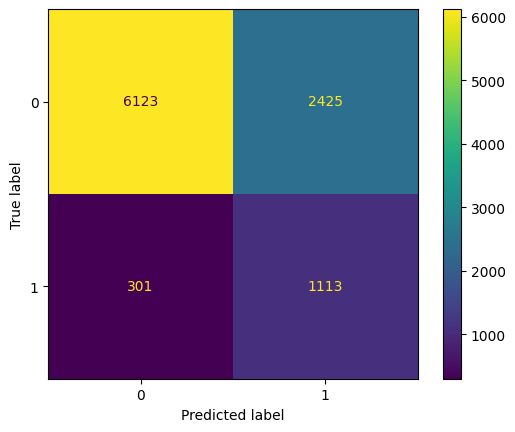

TPR:  0.7871287128712872 FPR:  0.28369209171736076 Accuracy:  0.7263601686408352


In [ ]:
#Plot the Confusion Matrix:

disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

TN= cm[0,0]
TP=cm[1,1]
FP=cm[0,1]
FN=cm[1,0]

TPR= TP / (TP+FN)
FPR= FP / (FP+TN)
Accuracy = accuracy_score(test_log["has_diabetes"], y_log4_pred)

print('TPR: ',TPR, 'FPR: ',FPR, 'Accuracy: ', Accuracy)

We achieve a Accuracy of 71.91% wiht a high TPR (79.70%) and low FPR (29.37%)

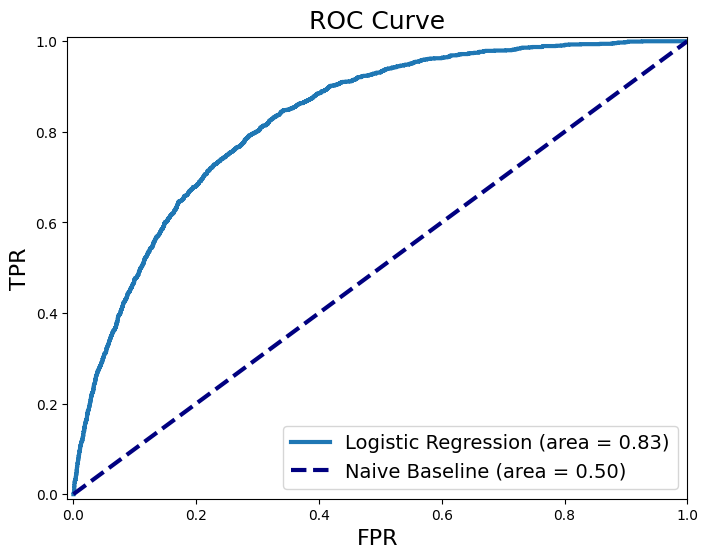

In [ ]:
#ROC-Curve

fpr, tpr, _ = roc_curve(test_log["has_diabetes"], y_log4_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='Logistic Regression (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', label='Naive Baseline (area = 0.50)')
plt.legend(loc='lower right', fontsize=14)
plt.show()

## Boosting Model Binary





### Pre Processing

The boosing Model reads the data and used NearMiss for undersampling and compares it with SMOTE for oversampling.

The idea to use this libaries where found on this page: https://www.comet.com/site/blog/resampling-to-properly-handle-imbalanced-datasets-in-machine-learning/

In [ ]:
# Loading data
train = pd.read_csv('/content/train_binary.csv')
test = pd.read_csv('/content/test_binary.csv')

X_train= train.drop('has_diabetes', axis=1)
y_train= train['has_diabetes']

X_test= test.drop('has_diabetes', axis=1)
y_test= test['has_diabetes']

# Near Miss
nm = NearMiss()
X_train_undersampled, y_train_undersampled = nm.fit_resample(X_train, y_train)

# Oversampling with SMOTE
smote = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

# Logging
print("Before doint anything:", y_train.value_counts())
print("After undersampling:", pd.Series(y_train_undersampled).value_counts())
print("After oversampling:", pd.Series(y_train_oversampled).value_counts())




Before doint anything: has_diabetes
0.0    205155
1.0     33932
Name: count, dtype: int64
After undersampling: has_diabetes
0.0    33932
1.0    33932
Name: count, dtype: int64
After oversampling: has_diabetes
1.0    205155
0.0    205155
Name: count, dtype: int64


### Training

In [ ]:
# Grid with some Hyperparameters (HP)
grid_values_gb = {
    'n_estimators': [50,150],
    'max_depth': [3, 7],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5],
    'random_state': [2024]
}


# ----- Undersampling ------
gb_undersampling = GradientBoostingClassifier(verbose=2)
gb_cv_undersampling = GridSearchCV(gb_undersampling, param_grid=grid_values_gb,scoring='accuracy', cv=10, verbose=2)
gb_cv_undersampling.fit(X_train_undersampled, y_train_undersampled)
gb_pred_test_undersampling = gb_cv_undersampling.best_estimator_.predict(X_test)

# ----- Oversampling ------ (Oversampling with CV took more than 6 hours to run, so we decided to use custom parameters)
gb_oversampling = GradientBoostingClassifier(verbose=2)
gb_oversampling.fit(X_train_oversampled, y_train_oversampled)
gb_pred_test_oversampling = gb_oversampling.predict(X_test)


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
       144           0.4593            0.95s
       145           0.4589            0.79s
       146           0.4586            0.63s
       147           0.4581            0.47s
       148           0.4578            0.31s
       149           0.4576            0.16s
       150           0.4572            0.00s
[CV] END max_depth=7, min_samples_leaf=1, min_samples_split=10, n_estimators=150, random_state=2024; total time=  23.6s
      Iter       Train Loss   Remaining Time 
         1           1.2708           18.61s
         2           1.1760           19.61s
         3           1.0966           19.80s
         4           1.0295           19.75s
         5           0.9723           19.59s
         6           0.9230           19.83s
         7           0.8800           19.60s
         8           0.8425           19.53s
         9           0.8091           19.30s
        10           0.7805           19.15s
  

### Evaluating

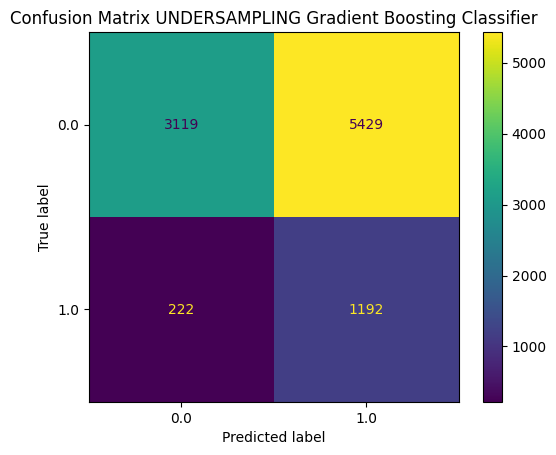

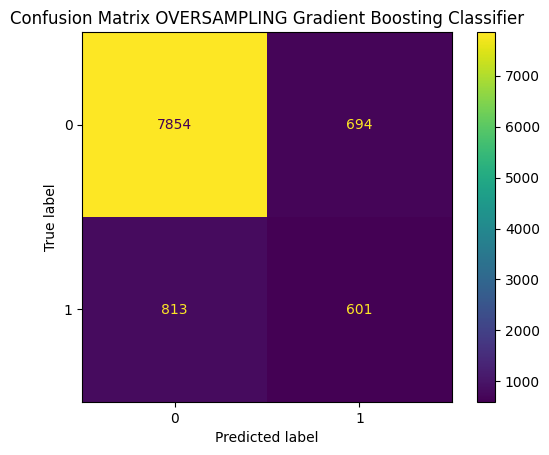

In [ ]:
# Plotting Confusion Matrices
conf_matrix_undersampling = confusion_matrix(y_test, gb_pred_test_undersampling)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_undersampling, display_labels=gb_cv_undersampling.classes_)
disp.plot()
plt.title("Confusion Matrix UNDERSAMPLING Gradient Boosting Classifier")
conf_matrix_oversampling = confusion_matrix(y_test, gb_pred_test_oversampling)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_oversampling, display_labels=[0,1])
disp.plot()
plt.title("Confusion Matrix OVERSAMPLING Gradient Boosting Classifier")
plt.show()


In [ ]:
# Calculating TP, TN, FP, FN, TPR, FPR and Acc

TN_oversampling= conf_matrix_oversampling[0,0]
TP_oversampling=conf_matrix_oversampling[1,1]
FP_oversampling=conf_matrix_oversampling[0,1]
FN_oversampling=conf_matrix_oversampling[1,0]

TN_undersampling = conf_matrix_undersampling[0,0]
TP_undersampling=conf_matrix_undersampling[1,1]
FP_undersampling=conf_matrix_undersampling[0,1]
FN_undersampling=conf_matrix_undersampling[1,0]

TPR_oversampling= TP_oversampling / (TP_oversampling+FN_oversampling)
FPR_oversampling= FP_oversampling / (FP_oversampling+TN_oversampling)
TPR_undersampling= TP_undersampling / (TP_undersampling+FN_undersampling)
FPR_undersampling= FP_undersampling / (FP_undersampling+TN_undersampling)

accuracy_oversampling = accuracy_score(y_test, gb_pred_test_oversampling)
accuracy_undersampling = accuracy_score(y_test, gb_pred_test_undersampling)

print(f"Accuracy oversampling: {accuracy_oversampling:.4f}, TPR oversampling: {TPR_oversampling:.4f}, FPR oversampling: {FPR_oversampling:.4f}")
print(f"Accuracy undersampling: {accuracy_undersampling:.4f}, TPR undersampling: {TPR_undersampling:.4f}, FPR undersampling: {FPR_undersampling:.4f}")


Accuracy oversampling: 0.8487, TPR oversampling: 0.4250, FPR oversampling: 0.0812
Accuracy undersampling: 0.4327, TPR undersampling: 0.8430, FPR undersampling: 0.6351


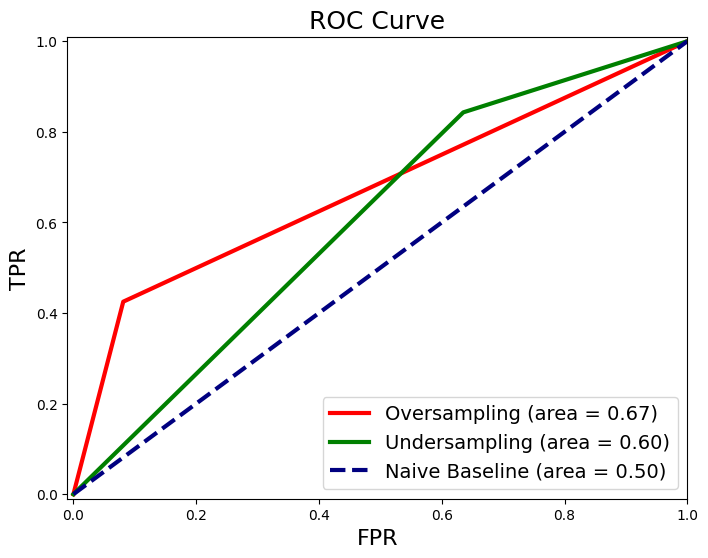

In [ ]:
#ROC-Curve

# Oversampling (red)
fpr_over, tpr_over, _ = roc_curve(y_test, gb_pred_test_oversampling)
roc_auc_oversampling = auc(fpr_over, tpr_over)
# Undersampling (green)
fpr_under, tpr_under, _ = roc_curve(y_test, gb_pred_test_undersampling)
roc_auc_undersampling = auc(fpr_under, tpr_under)

plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_over, tpr_over, lw=3,color="red", label='Oversampling (area = {:0.2f})'.format(roc_auc_oversampling))
plt.plot(fpr_under, tpr_under, lw=3,color="green", label='Undersampling (area = {:0.2f})'.format(roc_auc_undersampling))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', label='Naive Baseline (area = 0.50)')
plt.legend(loc='lower right', fontsize=14)


plt.show()

## LDA (Binary)

We have also used NearMiss for undersampling and compare it with SMOTE for oversampling while working with the LDA model.

#### Pre Processing ####

In [ ]:
#loading in the datasets

train = pd.read_csv('/content/train_binary.csv')
test = pd.read_csv('/content/test_binary.csv')

# separating features and target variable
X_train = train.drop(columns=['has_diabetes'])
y_train = train['has_diabetes']

X_test = test.drop(columns=['has_diabetes'])
y_test = test['has_diabetes']

# feature scaling to standardize them
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# writing functions to both undersample (NearMiss) and oversample (SMOTE)

def apply_smote(X_train, y_train, random_state=42):
    smote = SMOTE(random_state=random_state)
    return smote.fit_resample(X_train, y_train)

def apply_nearmiss(X_train, y_train):
    nm = NearMiss()
    return nm.fit_resample(X_train, y_train)

# Applying each resampling method
X_train_smote, y_train_smote = apply_smote(X_train, y_train)
X_train_nm, y_train_nm = apply_nearmiss(X_train, y_train)

# Logging all these changes
print("Before resampling:")
print(y_train.value_counts())
print("\nAfter overresampling (SMOTE):")
print(pd.Series(y_train_smote).value_counts())
print("\nAfter undersampling (NearMiss):")
print(pd.Series(y_train_nm).value_counts())

Before resampling:
has_diabetes
0.0    205155
1.0     33932
Name: count, dtype: int64

After overresampling (SMOTE):
has_diabetes
1.0    205155
0.0    205155
Name: count, dtype: int64

After undersampling (NearMiss):
has_diabetes
0.0    33932
1.0    33932
Name: count, dtype: int64


#### Training

In [ ]:
# Initializing and training the base LDA model
model_LDA = LDA(solver='lsqr', shrinkage='auto')  # Adding regularization
model_LDA.fit(X_train, y_train)

# also training LDA on the balanced datasets

#oversampled SMOTE
model_LDA_smote = LDA(solver='lsqr', shrinkage='auto')
model_LDA_smote.fit(X_train_smote, y_train_smote)

#undersampled NearMiss
model_LDA_nm = LDA(solver='lsqr', shrinkage='auto')
model_LDA_nm.fit(X_train_nm, y_train_nm)


LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')

#### Evaluating

In [ ]:
# making predictions on our baseline LDA model
y_pred_prob = model_LDA.predict_proba(X_test)[:, 1]  # Probabilities for class 1
threshold = 0.5  # Default threshold for initial evaluation
y_pred = (y_pred_prob >= threshold).astype(int)
# evaluating the model accuracy
accuracy_baseline = accuracy_score(y_test, y_pred)


# making predictions on our oversampling SMOTE model
y_pred_prob_smote = model_LDA_smote.predict_proba(X_test)[:, 1]  # Probabilities for class 1
threshold = 0.5  # Default threshold for initial evaluation
y_pred_smote = (y_pred_prob_smote >= threshold).astype(int)
# evaluating the SMOTE model accuracy
accuracy_smote = accuracy_score(y_test, y_pred_smote)


# making predictions on our undersampling NearMiss Model
y_pred_prob_nm = model_LDA_nm.predict_proba(X_test)[:, 1]  # Probabilities for class 1
threshold = 0.5  # Default threshold for initial evaluation
y_pred_nm = (y_pred_prob_nm >= threshold).astype(int)
# evaluating the NearMiss model accuracy
accuracy_nm = accuracy_score(y_test, y_pred_nm)

print(f'LDA Test Accuracy: {accuracy_baseline:.4f}')
print(f'LDA (SMOTE) Test Accuracy: {accuracy_smote:.4f}')
print(f'LDA (NearMiss) Test Accuracy: {accuracy_nm:.4f}')

LDA Test Accuracy: 0.8609
LDA (SMOTE) Test Accuracy: 0.7302
LDA (NearMiss) Test Accuracy: 0.6357


Text(0.5, 1.0, 'Confusion Matrix UNDERSAMPLING Linear Discriminant Analysis')

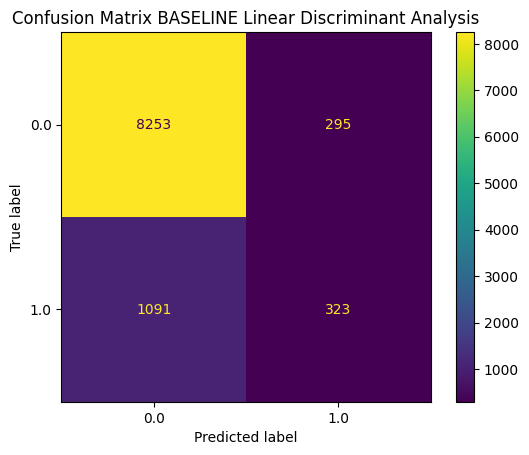

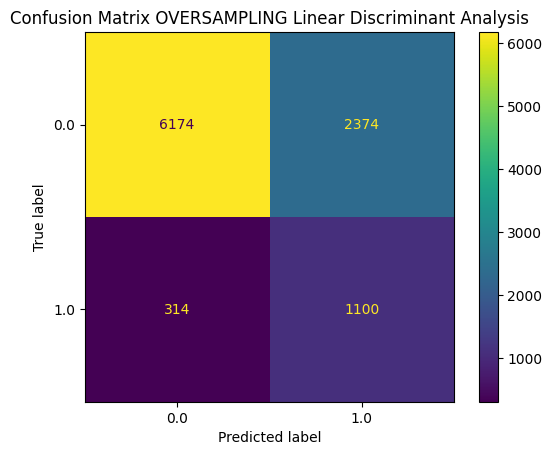

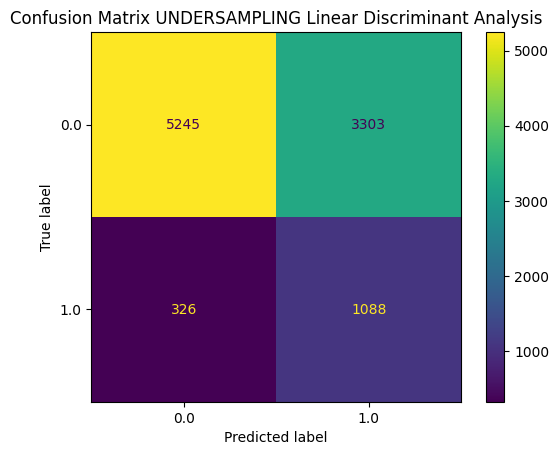

In [ ]:
# Confusion Matrices for all our LDA models (baseline, SMOTE, NearMiss)

#baseline
conf_matrix_baseline = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_baseline, display_labels=model_LDA.classes_)
disp.plot()
plt.title("Confusion Matrix BASELINE Linear Discriminant Analysis")

#oversampling - SMOTE
conf_matrix_smote = confusion_matrix(y_test, y_pred_smote)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_smote, display_labels=model_LDA_smote.classes_)
disp.plot()
plt.title("Confusion Matrix OVERSAMPLING Linear Discriminant Analysis")

#undersampling - NearMiss
conf_matrix_nm = confusion_matrix(y_test, y_pred_nm)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_nm, display_labels=model_LDA_nm.classes_)
disp.plot()
plt.title("Confusion Matrix UNDERSAMPLING Linear Discriminant Analysis")


In [ ]:
# [BASELINE]

#evaluating False Positives/Negatives and True Positives/Negatives --> False Positive Rate and True Negative Rates

cm = confusion_matrix(y_test, y_pred)

TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

accuracy = accuracy_score(y_test, y_pred)

# Print results
print(f"Confusion Matrix:\n{cm}")
print(f"True Positive Rate (TPR): {TPR:.4f}")
print(f"False Positive Rate (FPR): {FPR:.4f}")
print(f"Accuracy: {accuracy:.4f}")


Confusion Matrix:
[[8253  295]
 [1091  323]]
True Positive Rate (TPR): 0.2284
False Positive Rate (FPR): 0.0345
Accuracy: 0.8609


In [ ]:
# [OVERSAMPLED - SMOTE]

#evaluating False Positives/Negatives and True Positives/Negatives --> False Positive Rate and True Negative Rates

cm_s = confusion_matrix(y_test, y_pred_smote)

TN = cm_s[0, 0]
FP = cm_s[0, 1]
FN = cm_s[1, 0]
TP = cm_s[1, 1]

TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

accuracy_s = accuracy_score(y_test, y_pred_smote)

# Print results
print(f"Confusion Matrix:\n{cm_s}")
print(f"True Positive Rate (TPR): {TPR:.4f}")
print(f"False Positive Rate (FPR): {FPR:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Confusion Matrix:
[[6174 2374]
 [ 314 1100]]
True Positive Rate (TPR): 0.7779
False Positive Rate (FPR): 0.2777
Accuracy: 0.8609


In [ ]:
# [UNDERSAMPLED - NearMiss]

#evaluating False Positives/Negatives and True Positives/Negatives --> False Positive Rate and True Negative Rates

cm_nm = confusion_matrix(y_test, y_pred_nm)

TN = cm_nm[0, 0]
FP = cm_nm[0, 1]
FN = cm_nm[1, 0]
TP = cm_nm[1, 1]

TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

accuracy_nm = accuracy_score(y_test, y_pred_nm)

# Print results
print(f"Confusion Matrix:\n{cm_nm}")
print(f"True Positive Rate (TPR): {TPR:.4f}")
print(f"False Positive Rate (FPR): {FPR:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Confusion Matrix:
[[5245 3303]
 [ 326 1088]]
True Positive Rate (TPR): 0.7694
False Positive Rate (FPR): 0.3864
Accuracy: 0.8609


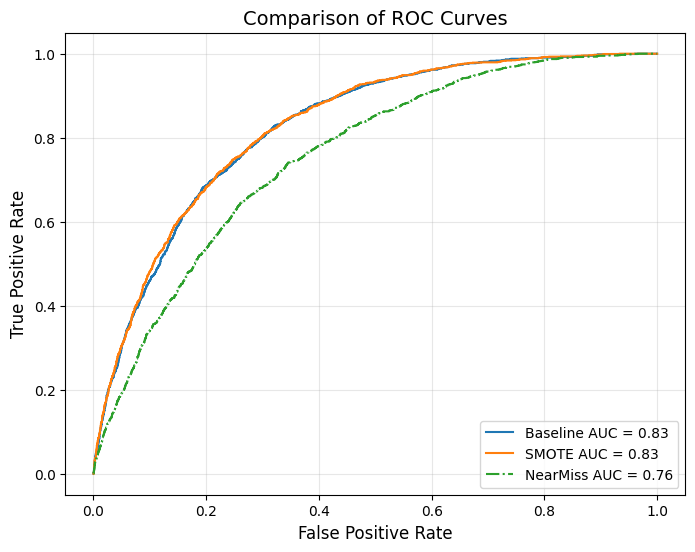

In [ ]:
# Plotting ROC Curves

# baseline model
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = auc(fpr, tpr)

#smote
fpr_smote, tpr_smote, thresholds_smote = roc_curve(y_test, y_pred_prob_smote)
auc_score_smote = auc(fpr_smote, tpr_smote)

#nearmiss
fpr_nm, tpr_nm, thresholds_nm = roc_curve(y_test, y_pred_prob_nm)
auc_score_nm = auc(fpr_nm, tpr_nm)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Baseline AUC = {auc_score:.2f}', linestyle='-')
plt.plot(fpr_smote, tpr_smote, label=f'SMOTE AUC = {auc_score_smote:.2f}', linestyle='-')
plt.plot(fpr_nm, tpr_nm, label=f'NearMiss AUC = {auc_score_nm:.2f}', linestyle='-.')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Comparison of ROC Curves', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.show()

Optimal Threshold: 0.11
Optimized LDA Test Accuracy : 0.6996
Optimized Confusion Matrix [Baseline]:


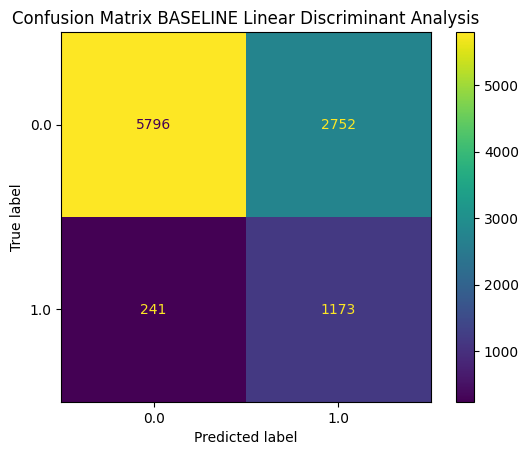

In [ ]:
# Optimizing our Threshold + Reevaluating using this optimal threshold [BASELINE]
optimal_idx_b = (tpr - fpr).argmax()
optimal_threshold_b = thresholds[optimal_idx_b]
print(f"Optimal Threshold: {optimal_threshold_b:.2f}")

# Re-evaluate using the optimal threshold
y_pred_optimal_b = (y_pred_prob >= optimal_threshold_b).astype(int)
accuracy_optimal_b = accuracy_score(y_test, y_pred_optimal_b)
conf_matrix_optimal_b = confusion_matrix(y_test, y_pred_optimal_b)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_optimal_b, display_labels=model_LDA.classes_)
disp.plot()
plt.title("Confusion Matrix BASELINE Linear Discriminant Analysis")

print(f'Optimized LDA Test Accuracy : {accuracy_optimal_b:.4f}')
print("Optimized Confusion Matrix [Baseline]:")

In [ ]:
# [Optimized - BASELINE]

#evaluating False Positives/Negatives and True Positives/Negatives --> False Positive Rate and True Negative Rates

cm = confusion_matrix(y_test, y_pred_optimal_b)

TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

accuracy = accuracy_score(y_test, y_pred_optimal_b)

# Print results
print(f"Confusion Matrix:\n{cm}")
print(f"True Positive Rate (TPR): {TPR:.4f}")
print(f"False Positive Rate (FPR): {FPR:.4f}")
print(f"Accuracy: {accuracy:.4f}")


Confusion Matrix:
[[5796 2752]
 [ 241 1173]]
True Positive Rate (TPR): 0.8296
False Positive Rate (FPR): 0.3219
Accuracy: 0.6996


Optimal Threshold (SMOTE): 0.47
Optimized LDA (SMOTE) Test Accuracy: 0.7131
Optimized Confusion Matrix (SMOTE):


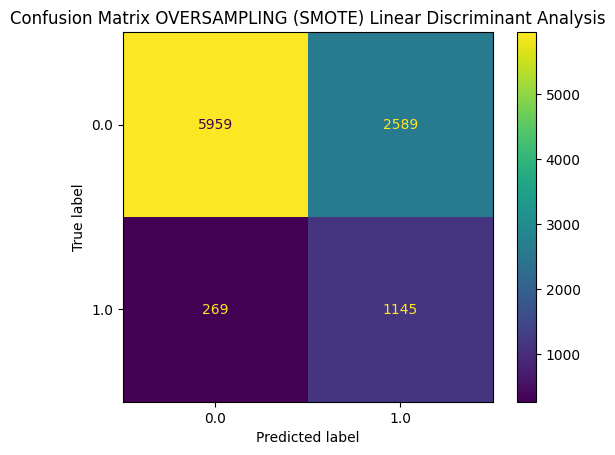

In [ ]:
# Optimizing our Threshold + Reevaluating using this optimal threshold [SMOTE]
optimal_idx_smote = (tpr_smote - fpr_smote).argmax()
optimal_threshold_smote = thresholds_smote[optimal_idx_smote]
print(f"Optimal Threshold (SMOTE): {optimal_threshold_smote:.2f}")

# Re-evaluate using the optimal threshold
y_pred_optimal_smote = (y_pred_prob_smote >= optimal_threshold_smote).astype(int)
accuracy_optimal_smote = accuracy_score(y_test, y_pred_optimal_smote)
conf_matrix_optimal_smote = confusion_matrix(y_test, y_pred_optimal_smote)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_optimal_smote, display_labels=model_LDA_smote.classes_)
disp.plot()
plt.title("Confusion Matrix OVERSAMPLING (SMOTE) Linear Discriminant Analysis")

print(f'Optimized LDA (SMOTE) Test Accuracy: {accuracy_optimal_smote:.4f}')
print("Optimized Confusion Matrix (SMOTE):")

In [ ]:
# [OVERSAMPLED - SMOTE]

#evaluating False Positives/Negatives and True Positives/Negatives --> False Positive Rate and True Negative Rates

cm_s = confusion_matrix(y_test, y_pred_optimal_smote)

TN = cm_s[0, 0]
FP = cm_s[0, 1]
FN = cm_s[1, 0]
TP = cm_s[1, 1]

TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

accuracy_s = accuracy_score(y_test, y_pred_optimal_smote)

# Print results
print(f"Confusion Matrix:\n{cm_s}")
print(f"True Positive Rate (TPR): {TPR:.4f}")
print(f"False Positive Rate (FPR): {FPR:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Confusion Matrix:
[[5959 2589]
 [ 269 1145]]
True Positive Rate (TPR): 0.8098
False Positive Rate (FPR): 0.3029
Accuracy: 0.6996


Optimal Threshold (NearMiss): 0.58
Optimized LDA (NearMiss) Test Accuracy: 0.6668
Optimized Confusion Matrix (NearMiss):


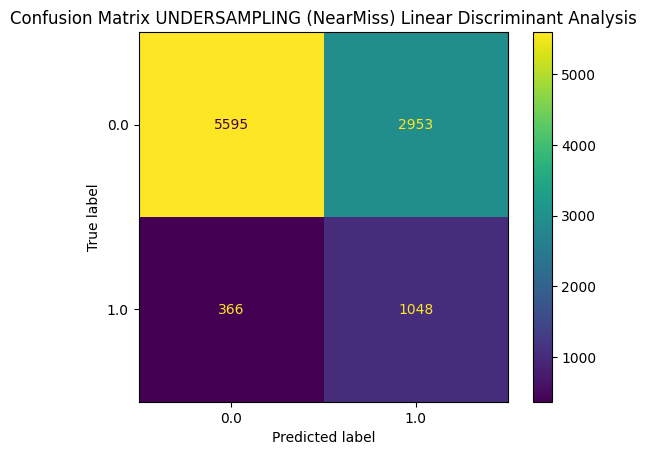

In [ ]:
# Optimizing our Threshold + Reevaluating using this optimal threshold [NearMiss]
optimal_idx_nm = (tpr_nm - fpr_nm).argmax()
optimal_threshold_nm = thresholds_nm[optimal_idx_nm]
print(f"Optimal Threshold (NearMiss): {optimal_threshold_nm:.2f}")

# Re-evaluate using the optimal threshold
y_pred_optimal_nm = (y_pred_prob_nm >= optimal_threshold_nm).astype(int)
accuracy_optimal_nm = accuracy_score(y_test, y_pred_optimal_nm)
conf_matrix_optimal_nm = confusion_matrix(y_test, y_pred_optimal_nm)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_optimal_nm, display_labels=model_LDA_nm.classes_)
disp.plot()
plt.title("Confusion Matrix UNDERSAMPLING (NearMiss) Linear Discriminant Analysis")

print(f'Optimized LDA (NearMiss) Test Accuracy: {accuracy_optimal_nm:.4f}')
print("Optimized Confusion Matrix (NearMiss):")

In [ ]:
# [UNDERSAMPLED - NearMiss]

#evaluating False Positives/Negatives and True Positives/Negatives --> False Positive Rate and True Negative Rates

cm_nm = confusion_matrix(y_test, y_pred_optimal_nm)

TN = cm_nm[0, 0]
FP = cm_nm[0, 1]
FN = cm_nm[1, 0]
TP = cm_nm[1, 1]

TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

accuracy_s = accuracy_score(y_test, y_pred_optimal_nm)

# Print results
print(f"Confusion Matrix:\n{cm_s}")
print(f"True Positive Rate (TPR): {TPR:.4f}")
print(f"False Positive Rate (FPR): {FPR:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Confusion Matrix:
[[5959 2589]
 [ 269 1145]]
True Positive Rate (TPR): 0.7412
False Positive Rate (FPR): 0.3455
Accuracy: 0.6996


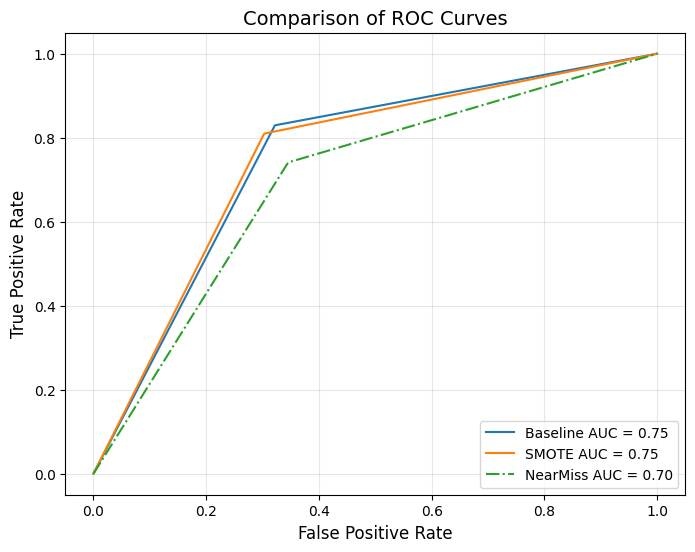

In [ ]:
# Plotting ROC Curves for these new optimized models

# baseline model
fpr, tpr, thresholds = roc_curve(y_test, y_pred_optimal_b)
auc_score = auc(fpr, tpr)

#smote
fpr_smote, tpr_smote, thresholds_smote = roc_curve(y_test, y_pred_optimal_smote)
auc_score_smote = auc(fpr_smote, tpr_smote)

#nearmiss
fpr_nm, tpr_nm, thresholds_nm = roc_curve(y_test, y_pred_optimal_nm)
auc_score_nm = auc(fpr_nm, tpr_nm)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Baseline AUC = {auc_score:.2f}', linestyle='-')
plt.plot(fpr_smote, tpr_smote, label=f'SMOTE AUC = {auc_score_smote:.2f}', linestyle='-')
plt.plot(fpr_nm, tpr_nm, label=f'NearMiss AUC = {auc_score_nm:.2f}', linestyle='-.')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Comparison of ROC Curves', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.show()

## Cart (Binary)

### Pre Processing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error


train = pd.read_csv('/content/train_binary.csv')
test = pd.read_csv('/content/test_binary.csv')

X_train= pd.get_dummies(train.drop(['has_diabetes'], axis=1))
y_train= train['has_diabetes']

X_test= pd.get_dummies(test.drop(['has_diabetes'], axis=1))
y_test= test['has_diabetes']

### Training

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(min_samples_leaf=5,
                             ccp_alpha=0.001,
                             random_state = 88)

dtc = dtc.fit(X_train, y_train)

Node count = 13


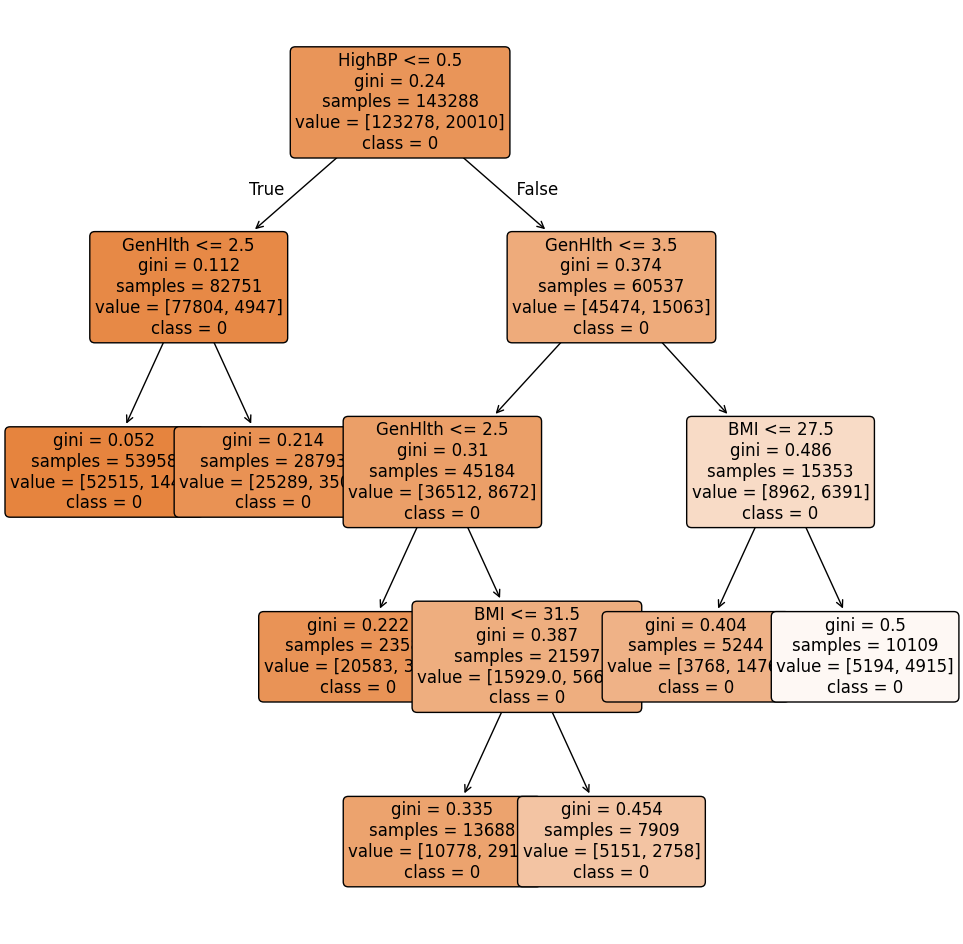

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

print('Node count =', dtc.tree_.node_count)
plt.figure(figsize=(12,12))
plot_tree(dtc,
          feature_names=X_train.columns,
          class_names=['0','1'],
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=12)
plt.show()

In [ ]:
y_pred = dtc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print ("Confusion Matrix : \n", cm)
# print('Precision:',precision_score(y_test, y_pred))
# print('Recall:',recall_score(y_test, y_pred))

acc = (cm.ravel()[0]+cm.ravel()[3])/sum(cm.ravel())
TPR = cm.ravel()[3]/(cm.ravel()[3]+cm.ravel()[2])
FPR = cm.ravel()[1]/(cm.ravel()[1]+cm.ravel()[0])
print('Accuracy is: %.4f' %acc)
print('TPR is: %.4f' % TPR)
print('FPR is: %.4f' % FPR)

Confusion Matrix : 
 [[5137    0]
 [ 834    0]]
Accuracy is: 0.8603
TPR is: 0.0000
FPR is: 0.0000


In [ ]:
dtc = accuracy_score(y_test, y_pred)
print(f'CV CART Test Accuracy: {dtc:.4f}')

CV CART Test Accuracy: 0.8595


### Cross-validation

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_values = {
    'ccp_alpha': np.linspace(0, 0.10, 201),
    'min_samples_leaf': [5],
    'min_samples_split': [20],
    'max_depth': [30],
    'random_state': [88]
}

dtc = DecisionTreeClassifier()
dtc_cv_acc = GridSearchCV(dtc, param_grid = grid_values, scoring = 'accuracy', cv=10, verbose=1)
dtc_cv_acc.fit(X_train, y_train)

Fitting 10 folds for each of 201 candidates, totalling 2010 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
       0.004 , 0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075,
       0.008 , 0.0085, 0.009 , 0.0095, 0.01  , 0.0105, 0.011 , 0.0115,
       0.012 , 0.0125, 0.013 , 0.0135, 0.014 , 0.0145, 0.015 , 0.0155,
       0.016 , 0.0165, 0.017 , 0.0175, 0.018 , 0.0185, 0.019 , 0.0195,
       0.02  , 0.02...
       0.08  , 0.0805, 0.081 , 0.0815, 0.082 , 0.0825, 0.083 , 0.0835,
       0.084 , 0.0845, 0.085 , 0.0855, 0.086 , 0.0865, 0.087 , 0.0875,
       0.088 , 0.0885, 0.089 , 0.0895, 0.09  , 0.0905, 0.091 , 0.0915,
       0.092 , 0.0925, 0.093 , 0.0935, 0.094 , 0.0945, 0.095 , 0.0955,
       0.096 , 0.0965, 0.097 , 0.0975, 0.098 , 0.0985, 0.099 , 0.0995,
       0.1   ]),
                         'max_depth': [30], 'min_samples_leaf': [5],
                         'min_samples_split': [20], 'random_state': [88]},
             scoring='accuracy', verbose=1)

In [ ]:
acc = dtc_cv_acc.cv_results_['mean_test_score'] # what sklearn calls mean_test_score is the holdout set, i.e. the validation set.
ccp = dtc_cv_acc.cv_results_['param_ccp_alpha'].data

pd.DataFrame({'ccp alpha' : ccp, 'Validation Accuracy': acc}).head(20)

,ccp alpha,Validation Accuracy
0,0.0000,0.845123
1,0.0005,0.864839
2,0.0010,0.860972
3,0.0015,0.860693
4,0.0020,0.860351
5,0.0025,0.860351
6,0.0030,0.860351
7,0.0035,0.860351
8,0.0040,0.860351
9,0.0045,0.860351


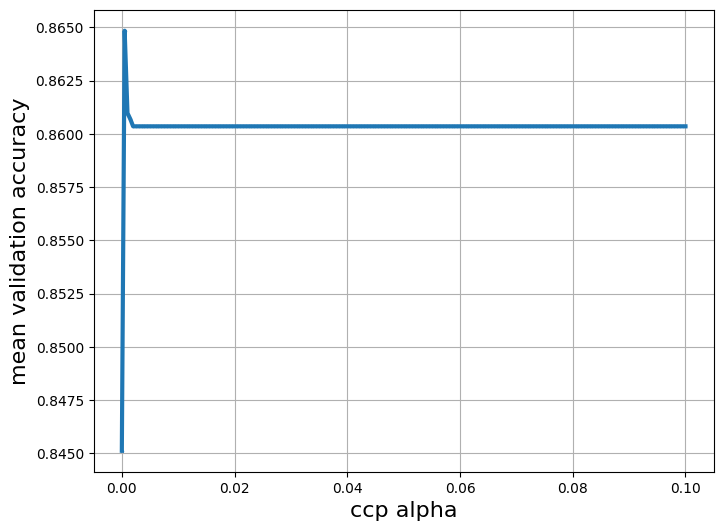

In [ ]:
plt.figure(figsize=(8, 6))
plt.xlabel('ccp alpha', fontsize=16)
plt.ylabel('mean validation accuracy', fontsize=16)
plt.scatter(ccp, acc, s=2)
plt.plot(ccp, acc, linewidth=3)
plt.grid(True, which='both')
plt.show()

In [ ]:
print('Grid best parameter ccp_alpha (max. accuracy): ', dtc_cv_acc.best_params_['ccp_alpha'])
print('Grid best score (accuracy): ', dtc_cv_acc.best_score_)

Grid best parameter ccp_alpha (max. accuracy):  0.0005
Grid best score (accuracy):  0.8648386550115518


Node count = 21


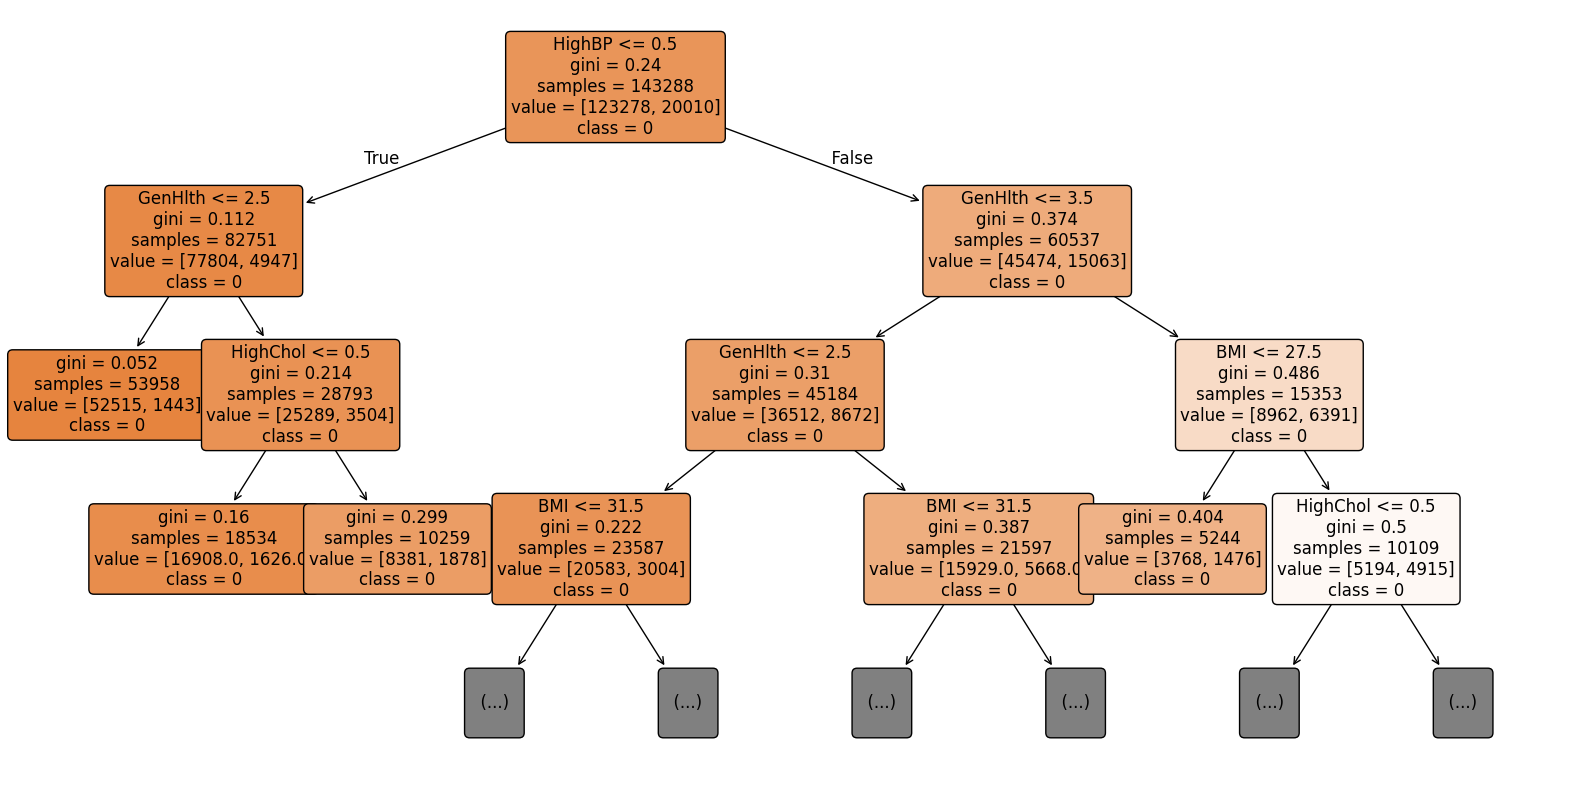

In [ ]:
print('Node count =', dtc_cv_acc.best_estimator_.tree_.node_count)

plt.figure(figsize=(20,10))
plot_tree(dtc_cv_acc.best_estimator_,
          feature_names=X_train.columns,
          class_names=['0','1'],
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=12,
          max_depth=3)
plt.show()

In [ ]:
y_pred = dtc_cv_acc.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print ("Confusion Matrix : \n", cm)
# print('Precision:',precision_score(y_test, y_pred))
# print('Recall:',recall_score(y_test, y_pred))

acc = (cm.ravel()[0]+cm.ravel()[3])/sum(cm.ravel())
TPR = cm.ravel()[3]/(cm.ravel()[3]+cm.ravel()[2])
FPR = cm.ravel()[1]/(cm.ravel()[1]+cm.ravel()[0])
print('Accuracy is: %.4f' %acc)
print('TPR is: %.4f' % TPR)
print('FPR is: %.4f' % FPR)

Confusion Matrix : 
 [[4992  145]
 [ 694  140]]
Accuracy is: 0.8595
TPR is: 0.1679
FPR is: 0.0282


In [ ]:
print('Grid best parameter ccp_alpha (max. accuracy): ', dtc_cv_acc.best_params_['ccp_alpha'])
print('Grid best score (accuracy): ', dtc_cv_acc.best_score_)

Grid best parameter ccp_alpha (max. accuracy):  0.0005
Grid best score (accuracy):  0.8648386550115518


### After CV

In [ ]:
dtc2 = DecisionTreeClassifier(min_samples_leaf=5,
                             ccp_alpha=0.0005,
                             random_state = 88)

dtc2 = dtc2.fit(X_train, y_train)


Node count = 21


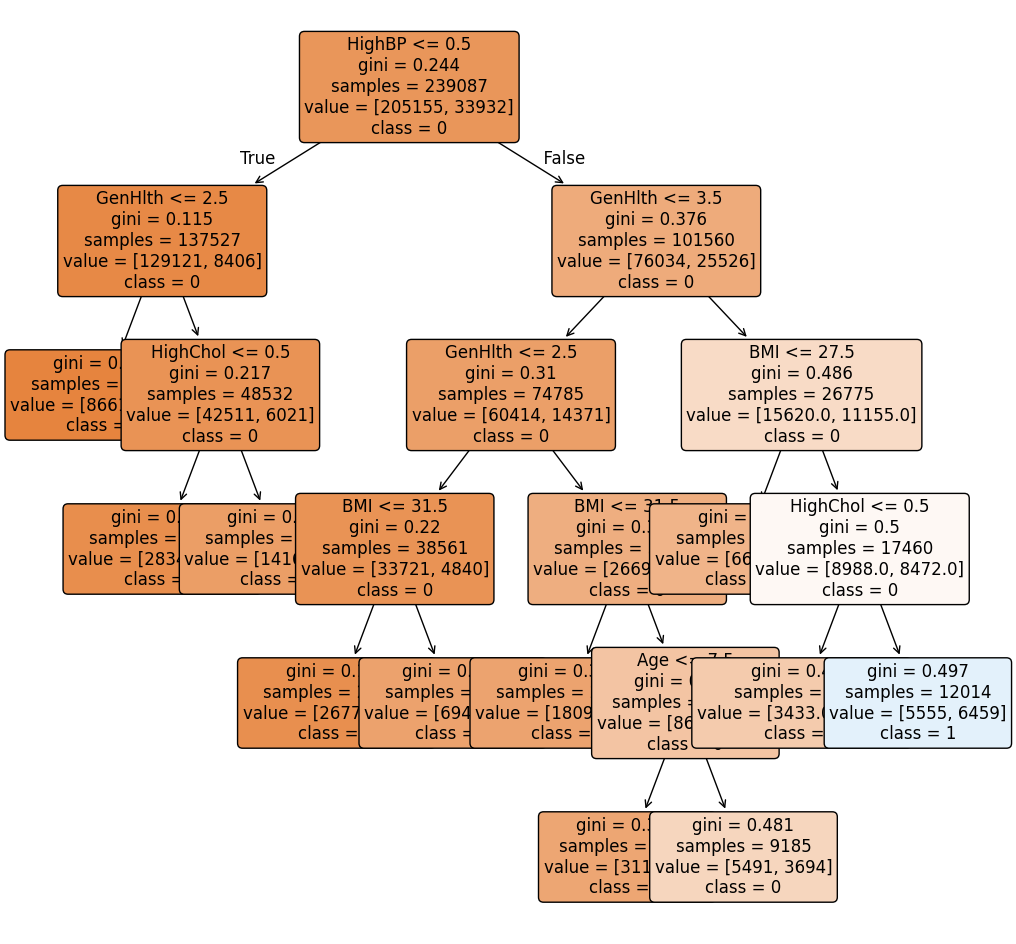

In [ ]:

from sklearn.tree import plot_tree
print('Node count =', dtc2.tree_.node_count)
plt.figure(figsize=(12,12))
plot_tree(dtc2,
          feature_names=X_train.columns,
          class_names=['0','1'],
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=12)
plt.show()

### Evaluating

In [ ]:
y_pred = dtc2.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print ("Confusion Matrix : \n", cm)
print('Precision:',precision_score(y_test, y_pred))
print('Recall:',recall_score(y_test, y_pred))

acc = (cm.ravel()[0]+cm.ravel()[3])/sum(cm.ravel())
TPR = cm.ravel()[3]/(cm.ravel()[3]+cm.ravel()[2])
FPR = cm.ravel()[1]/(cm.ravel()[1]+cm.ravel()[0])
print('Accuracy is: %.4f' %acc)
print('TPR is: %.4f' % TPR)
print('FPR is: %.4f' % FPR)

Confusion Matrix : 
 [[8314  234]
 [1126  288]]
Precision: 0.5517241379310345
Recall: 0.2036775106082037
Accuracy is: 0.8635
TPR is: 0.2037
FPR is: 0.0274


Text(0.5, 1.0, 'Confusion Matrix UDERSAMPLING Gradient CART Classifier')

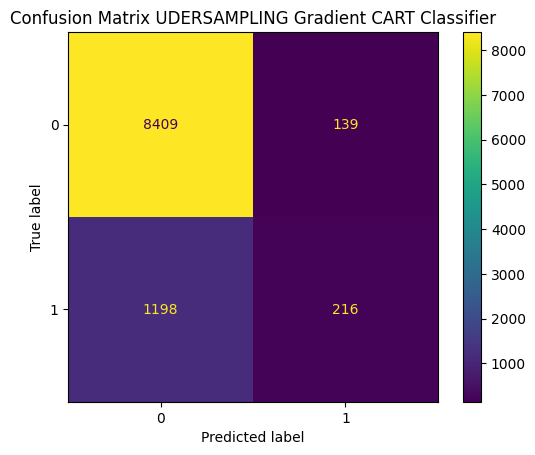

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix Gradient CART Classifier")

In [ ]:
dtc2 = accuracy_score(y_test, y_pred)
print(f'CV CART Test Accuracy: {dtc2:.4f}')

CV CART Test Accuracy: 0.8595


## Random Forest (Binary)

### Pre Processing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error


train = pd.read_csv('/content/train_binary.csv')
test = pd.read_csv('/content/test_binary.csv')

X_train= pd.get_dummies(train.drop(['has_diabetes'], axis=1))
y_train= train['has_diabetes']

X_test= pd.get_dummies(test.drop(['has_diabetes'], axis=1))
y_test= test['has_diabetes']

### Training

In [ ]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


tic = time.time()

rf = RandomForestClassifier(max_features = len(X_train.columns),random_state = 2024)
rf.fit(X_train, y_train)
y_prob = rf.predict_proba(X_test)
y_pred = [1 if pred > 0.5 else 0 for pred in y_prob[:,1]]

rf_acc = accuracy_score(y_test,y_pred)
print(f'Random Forest Test Accuracy: {rf_acc:.4f}')

toc = time.time()

print('time:', round(toc-tic, 2),'s')

Random Forest Test Accuracy: 0.8524
time: 168.58 s


In [ ]:
y_test_above = y_test[y_test >0.1]
X_test_above = X_test[y_test >0.1]

y_test_below = y_test[y_test <=0.1]
X_test_below = X_test[y_test <=0.1]

MAE_rf_above = mean_absolute_error(y_test_above, rf.predict(X_test_above))
MAE_rf_below = mean_absolute_error(y_test_below, rf.predict(X_test_below))

print('Random Forest Out-of-sample MAE for CTR above 10%:', round(MAE_rf_above, 3))
print('Random Forest Out-of-sample MAE for CTR below 10%:', round(MAE_rf_below, 3))


Random Forest Out-of-sample MAE for CTR above 10%: 0.76
Random Forest Out-of-sample MAE for CTR below 10%: 0.046


### Cross Validation

In [ ]:
tic = time.time()

params = {'max_features': np.arange(1, len(X_train.columns) + 1)}
rf = RandomForestClassifier(random_state = 2024)
rf_cv = GridSearchCV(rf, params, cv = 5, scoring ='accuracy',verbose = False)
rf_cv.fit(X_train, y_train)
# Make predictions
y_pred = rf_cv.best_estimator_.predict(X_test)
# Calculate accuracy
rf_acc = accuracy_score(y_test, y_pred)
print(f'CV Random Forest Test Accuracy: {rf_acc:.4f}')


toc = time.time()

print('time:', round(toc-tic, 2),'s')

### Evaluating

In [ ]:
max_features = rf_cv.cv_results_['param_max_features'].data
R2_scores = rf_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('max features', fontsize=16)
plt.ylabel('CV R2', fontsize=16)
plt.scatter(max_features, R2_scores, s=30)
plt.plot(max_features, R2_scores, linewidth=3)
plt.grid(True, which='both')
plt.show()

In [ ]:
print(rf_cv.best_params_)

In [ ]:
def OSR2(model, X_test, y_test, y_train):

    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)

    return (1 - SSE/SST)

In [ ]:
print('Cross-validated R2:', round(rf_cv.best_score_, 5))
print('OSR2:', round(OSR2(rf_cv, X_test, y_test, y_train), 5))

In [ ]:
pd.DataFrame({'Feature' : X_train.columns,
              'Importance score': 100*rf_cv.best_estimator_.feature_importances_}).round(1)


In [ ]:
plt.figure(figsize=(8,7))
plt.barh(X_train.columns, 100*rf_cv.best_estimator_.feature_importances_)
plt.show()

### After Cross-Validation

In [ ]:
tic = time.time()


params = {'max_features': [3],'min_samples_split': [2, 4, 6],'min_samples_leaf': [1, 3, 5]  }

rf2 = RandomForestClassifier(random_state=2024)
rf2_cv = GridSearchCV(rf2, params, cv=5, scoring='accuracy', verbose=False)
rf2_cv.fit(X_train, y_train)


y_pred = rf2_cv.best_estimator_.predict(X_test)

# Calculate accuracy
rf2_acc = accuracy_score(y_test, y_pred)
print(f'CV Random Forest Test Accuracy: {rf2_acc:.4f}')

toc = time.time()
print('time:', round(toc-tic, 2), 's')

In [ ]:
y_test_above = y_test[y_test >0.1]
X_test_above = X_test[y_test >0.1]

y_test_below = y_test[y_test <=0.1]
X_test_below = X_test[y_test <=0.1]

MAE_rf_above = mean_absolute_error(y_test_above, rf2_cv.predict(X_test_above))
MAE_rf_below = mean_absolute_error(y_test_below, rf2_cv.predict(X_test_below))

print('Random Forest Out-of-sample MAE for CTR above 10%:', round(MAE_rf_above, 3))
print('Random Forest Out-of-sample MAE for CTR below 10%:', round(MAE_rf_below, 3))


Confusion Matrices

In [ ]:
y_pred = rf2_cv.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print ("Confusion Matrix : \n", cm)
print('Precision:',precision_score(y_test, y_pred))
print('Recall:',recall_score(y_test, y_pred))

acc = (cm.ravel()[0]+cm.ravel()[3])/sum(cm.ravel())
TPR = cm.ravel()[3]/(cm.ravel()[3]+cm.ravel()[2])
FPR = cm.ravel()[1]/(cm.ravel()[1]+cm.ravel()[0])
print('Accuracy is: %.4f' %acc)
print('TPR is: %.4f' % TPR)
print('FPR is: %.4f' % FPR)

Confusion Matrix : 
 [[8409  139]
 [1198  216]]
Precision: 0.6084507042253521
Recall: 0.15275813295615276
Accuracy is: 0.8658
TPR is: 0.1528
FPR is: 0.0163


Text(0.5, 1.0, 'Confusion Matrix Gradient Random forest Classifier')

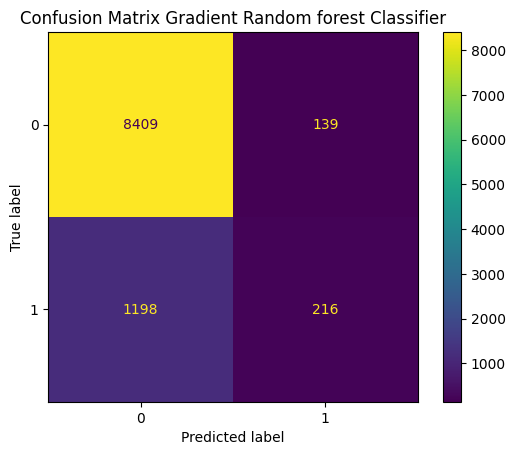

In [ ]:
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm)
disp_rf.plot()
plt.title("Confusion Matrix Gradient Random forest Classifier")

In [ ]:
# Confusion Matrix to Ascertain Accuracy, FPR and TPR
cm = confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = cm.ravel()

# calculating metrics
accuracy = (tp + tn) / (tn + fp + fn + tp)
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

print(f"Accuracy: {accuracy:.4f}")
print(f"TPR (Recall): {tpr:.4f}")
print(f"FPR: {fpr:.4f}")

Accuracy: 0.8635
TPR (Recall): 0.2037
FPR: 0.0274


## PyTorch Model (Binary)

Used Source: https://machinelearningmastery.com/building-a-binary-classification-model-in-pytorch/

https://www.dataquest.io/blog/pytorch-for-beginners/

### Data Pre Processing

In [ ]:
# Loading data
train = pd.read_csv('/content/train_binary.csv')
test = pd.read_csv('/content/test_binary.csv')

X_train= train.drop('has_diabetes', axis=1)
y_train= train['has_diabetes']

X_test= test.drop('has_diabetes', axis=1)
y_test= test['has_diabetes']


# Oversampling with SMOTE
smote = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

# Logging
print("Before doint anything:", y_train.value_counts())
print("After oversampling:", pd.Series(y_train_oversampled).value_counts())




Before doint anything: has_diabetes
0.0    205155
1.0     33932
Name: count, dtype: int64
After oversampling: has_diabetes
1.0    205155
0.0    205155
Name: count, dtype: int64


In [ ]:
# The data should be based on Tensors and in a Dataloader for Torch
X = torch.tensor(X_train_oversampled.to_numpy(), dtype=torch.float32)
y = torch.tensor(y_train_oversampled.to_numpy(), dtype=torch.float32).reshape(-1, 1)

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


### Training

In [ ]:
# Model with 2 hidden layer
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(21, 180)  #21 features, 180 neurons
        self.relu = nn.ReLU()

        # Second hidden layer
        self.hidden2 = nn.Linear(180, 90)  # 180 neurons -> 90 neurons
        self.relu2 = nn.ReLU()

        self.output = nn.Linear(90, 1) # 1 output neuron
        self.sigmoid = nn.Sigmoid() # Proab function

    def forward(self, x):
        x = self.relu(self.hidden(x))

        x = self.relu2(self.hidden2(x))

        x = self.sigmoid(self.output(x))
        return x



In [ ]:
model = Model()

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 15  # After 15 epochs we see a convergence of the loss
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        total_loss = total_loss +loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")

Epoch 1/15, Loss: 6308.0994
Epoch 2/15, Loss: 5421.6196
Epoch 3/15, Loss: 4585.9317
Epoch 4/15, Loss: 4331.1621
Epoch 5/15, Loss: 4208.1933
Epoch 6/15, Loss: 4153.3756
Epoch 7/15, Loss: 4107.3175
Epoch 8/15, Loss: 4052.9477
Epoch 9/15, Loss: 4013.7687
Epoch 10/15, Loss: 3953.5351
Epoch 11/15, Loss: 3857.3596
Epoch 12/15, Loss: 3797.6704
Epoch 13/15, Loss: 3752.5972
Epoch 14/15, Loss: 3726.4278
Epoch 15/15, Loss: 3700.7117


### Evaluating

In [ ]:
model.eval() # Turn the model Eval mode

# Convert X_test to a tensor (similar to X_train)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)


with torch.no_grad():  # Disable gradient calculations
    predictions = model(X_test_tensor)

# Treshold was found to be 0.5
torch_preds = (predictions >= 0.5).int()


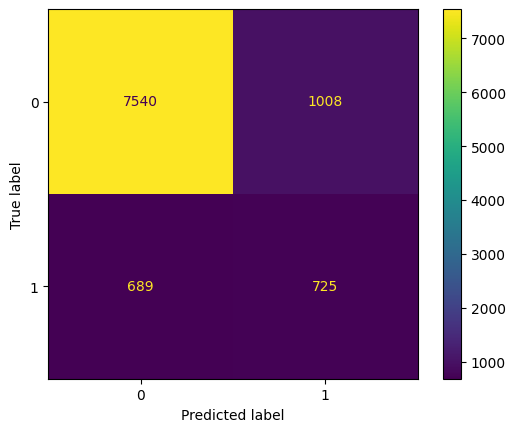

TPR:  tensor(0.5127) FPR:  tensor(0.1179) Accuracy:  0.8296526801847018


In [ ]:
#Plot the Confusion Matrix and calc TPR, FPR and Acc
confusion_matrix_torch= confusion_matrix(y_test, torch_preds)

disp = ConfusionMatrixDisplay(confusion_matrix_torch)
disp.plot()
plt.show()

TN= conf_matrix_torch[0,0]
TP=conf_matrix_torch[1,1]
FP=conf_matrix_torch[0,1]
FN=conf_matrix_torch[1,0]

TPR= TP / (TP+FN)
FPR= FP / (FP+TN)
Accuracy = accuracy_score(y_test, torch_preds)

print('TPR: ',TPR, 'FPR: ',FPR, 'Accuracy: ', Accuracy)

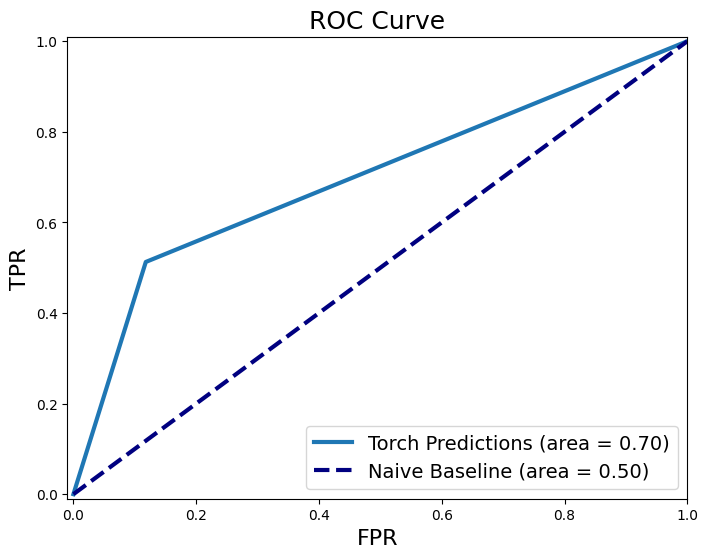

In [ ]:
#ROC-Curve

fpr, tpr, _ = roc_curve(y_test, torch_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='Torch Predictions (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', label='Naive Baseline (area = 0.50)')
plt.legend(loc='lower right', fontsize=14)
plt.show()

## Pulling It All Together - Binary Models

In [ ]:
import pandas as pd

# Data for the models
data = {
    'Model': [
        'Baseline Model',
        'Logistic Regression',
        'LDA (Original)',
        'LDA (Oversampling)',
        'LDA (Undersampling)',
        'CART',
        'Gradient Boosting (Oversampling)',
        'Gradient Boosting (Undersampling)',
        'Random Forest',
        'Torch',
    ],
    'Accuracy': [
        0.9788184108083352,
        0.7263601686408352,
        0.6996,
        0.6996,
        0.6996,
        0.8595,
        0.8487,
        0.4327,
        0.8658,
        0.8296,
    ],
    'TPR': [
        None,
        0.7871287128712872,
        0.8296,
        0.8098,
        0.7412,
        0.1679,
        0.4250,
        0.8430,
        0.1528,
        0.5127,
    ],
    'FPR': [
        None,
        0.28369209171736076,
        0.3219,
        0.3029,
        0.3455,
        0.0282,
        0.0812,
        0.6351,
        0.0163,
        0.1179,
    ]
}

# Create DataFrame
results_df = pd.DataFrame(data)

# Set title for the dataframe
results_df.name = "Binary Model Performance Comparison"

# Display the dataframe
print(results_df)

                               Model  Accuracy       TPR       FPR
0                     Baseline Model  0.978818       NaN       NaN
1                Logistic Regression  0.726360  0.787129  0.283692
2                     LDA (Original)  0.699600  0.829600  0.321900
3                 LDA (Oversampling)  0.699600  0.809800  0.302900
4                LDA (Undersampling)  0.699600  0.741200  0.345500
5                               CART  0.859500  0.167900  0.028200
6   Gradient Boosting (Oversampling)  0.848700  0.425000  0.081200
7  Gradient Boosting (Undersampling)  0.432700  0.843000  0.635100
8                      Random Forest  0.865800  0.152800  0.016300
9                              Torch  0.829600  0.512700  0.117900


# Multi Class

For this part we also include the third label "Pre-Diabetes

## Gradient Boosting

### Pre Processing

In [ ]:


train = pd.read_csv('/content/train_multiclass.csv')
test = pd.read_csv('/content/test_multiclass.csv')

X_train= train.drop('diabetes_type', axis=1)
y_train= train['diabetes_type']

X_test= test.drop('diabetes_type', axis=1)
y_test= test['diabetes_type']

# Near Miss
nm = NearMiss()
X_train_undersampled, y_train_undersampled = nm.fit_resample(X_train, y_train)

# Oversampling with SMOTE
smote = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

# Logging
print("Before doint anything:", y_train.value_counts())
print("After undersampling:", pd.Series(y_train_undersampled).value_counts())
print("After oversampling:", pd.Series(y_train_oversampled).value_counts())


Before doint anything: diabetes_type
0.0    205154
2.0     33932
1.0      4446
Name: count, dtype: int64
After undersampling: diabetes_type
0.0    4446
1.0    4446
2.0    4446
Name: count, dtype: int64
After oversampling: diabetes_type
0.0    205154
2.0    205154
1.0    205154
Name: count, dtype: int64


### Training

In [ ]:
# Grid with some models
grid_values_gb = {
    'n_estimators': [50,150],
    'max_depth': [3, 7],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5],
    'random_state': [2024]
}

# Accuracy is not a good measurement because data is imbalanced
# We decided to evaluate the CV on the f1_score
scorer = make_scorer(f1_score, average='macro')
# ----- Undersampling ------
gb_undersampling = GradientBoostingClassifier(verbose=2)
gb_cv_undersampling = GridSearchCV(gb_undersampling, param_grid=grid_values_gb,scoring=scorer, cv=10, verbose=2)
gb_cv_undersampling.fit(X_train_undersampled, y_train_undersampled)
gb_pred_test_undersampling = gb_cv_undersampling.best_estimator_.predict(X_test)

# ----- Oversampling ------ (Oversampling with CV took more than 4 hours to run, so we decided to use custom parameters)
gb_oversampling = GradientBoostingClassifier(verbose=2)

gb_oversampling.fit(X_train_oversampled, y_train_oversampled)
gb_pred_test_oversampling = gb_oversampling.predict(X_test)


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
        92           0.3939            6.11s
        93           0.3930            6.01s
        94           0.3922            5.89s
        95           0.3910            5.78s
        96           0.3897            5.67s
        97           0.3879            5.56s
        98           0.3866            5.44s
        99           0.3852            5.33s
       100           0.3838            5.22s
       101           0.3827            5.10s
       102           0.3813            4.99s
       103           0.3802            4.88s
       104           0.3793            4.77s
       105           0.3786            4.66s
       106           0.3773            4.55s
       107           0.3761            4.44s
       108           0.3748            4.34s
       109           0.3731            4.23s
       110           0.3714            4.12s
       111           0.3698            4.01s
       112           0.3689      

### Evaluation

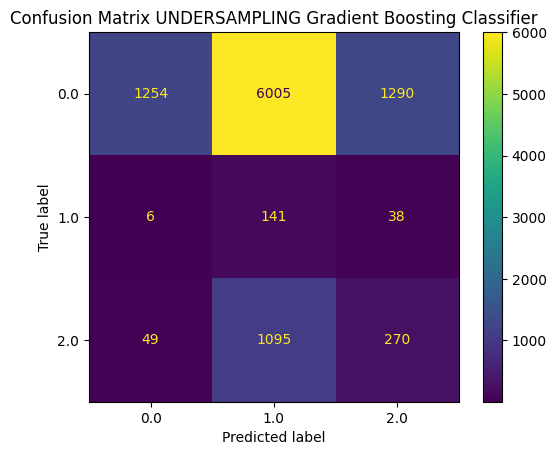

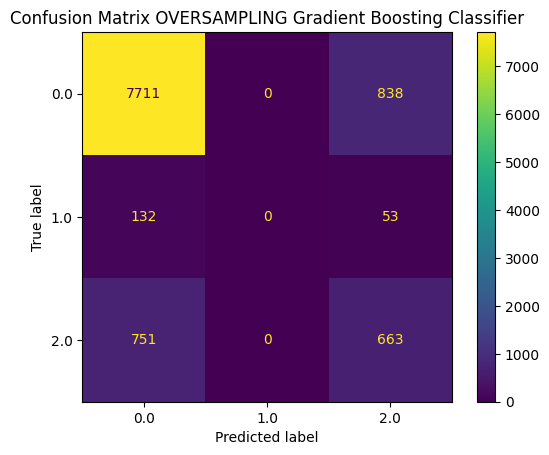

In [ ]:
conf_matrix_undersampling = confusion_matrix(y_test, gb_pred_test_undersampling)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_undersampling, display_labels=gb_cv_undersampling.classes_)
disp.plot()
plt.title("Confusion Matrix UNDERSAMPLING Gradient Boosting Classifier")

conf_matrix_oversampling = confusion_matrix(y_test, gb_pred_test_oversampling)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_oversampling, display_labels=gb_oversampling.classes_)
disp.plot()
plt.title("Confusion Matrix OVERSAMPLING Gradient Boosting Classifier")

plt.show()

In [ ]:

print("Classification Report Undersampling")
print(classification_report(y_test, gb_pred_test_undersampling))
print("\n\nClassification Report Undersampling")
print(classification_report(y_test, gb_pred_test_oversampling))

accuracy_oversampling = accuracy_score(y_test, gb_pred_test_oversampling)
accuracy_undersampling = accuracy_score(y_test, gb_pred_test_undersampling)

print(f"\n\nAccuracy oversampling: {accuracy_oversampling:.4f}")
print(f"Accuracy undersampling: {accuracy_undersampling:.4f}")


Classification Report Undersampling
              precision    recall  f1-score   support

         0.0       0.96      0.15      0.25      8549
         1.0       0.02      0.76      0.04       185
         2.0       0.17      0.19      0.18      1414

    accuracy                           0.16     10148
   macro avg       0.38      0.37      0.16     10148
weighted avg       0.83      0.16      0.24     10148



Classification Report Undersampling
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90      8549
         1.0       0.00      0.00      0.00       185
         2.0       0.43      0.47      0.45      1414

    accuracy                           0.83     10148
   macro avg       0.44      0.46      0.45     10148
weighted avg       0.82      0.83      0.82     10148



Accuracy oversampling: 0.8252
Accuracy undersampling: 0.1641


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## LDA

### Pre-Processing


In [ ]:
# loading in the datasets
train = pd.read_csv('/content/train_multiclass.csv')
test = pd.read_csv('/content/test_multiclass.csv')

# separating features and target variable
X_train = train.drop('diabetes_type', axis=1)
y_train = train['diabetes_type']

X_test = test.drop('diabetes_type', axis=1)
y_test = test['diabetes_type']


# feature scaling to standardize them
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# writing functions to both undersample (NearMiss) and oversample (SMOTE)
def apply_smote(X_train, y_train, random_state=42):
    smote = SMOTE(random_state=random_state)
    return smote.fit_resample(X_train, y_train)

def apply_nearmiss(X_train, y_train):
    nm = NearMiss()
    return nm.fit_resample(X_train, y_train)

# applying each resampling method
X_train_smote, y_train_smote = apply_smote(X_train, y_train)
X_train_nm, y_train_nm = apply_nearmiss(X_train, y_train)

# logging all these changes
print("Before resampling:")
print(y_train.value_counts())
print("\nAfter oversampling (SMOTE):")
print(pd.Series(y_train_smote).value_counts())
print("\nAfter undersampling (NearMiss):")
print(pd.Series(y_train_nm).value_counts())

Before resampling:
diabetes_type
0.0    205154
2.0     33932
1.0      4446
Name: count, dtype: int64

After oversampling (SMOTE):
diabetes_type
0.0    205154
2.0    205154
1.0    205154
Name: count, dtype: int64

After undersampling (NearMiss):
diabetes_type
0.0    4446
1.0    4446
2.0    4446
Name: count, dtype: int64


### Training

In [ ]:
# initializing our LDA models
model_lda_baseline = LDA()
model_lda_smote = LDA()
model_lda_nm = LDA()

# training LDA on baseline data
model_lda_baseline.fit(X_train, y_train)

# training LDA on oversampled data (SMOTE)
model_lda_smote.fit(X_train_smote, y_train_smote)

# training LDA on undersampled data (NearMiss)
model_lda_nm.fit(X_train_nm, y_train_nm)

LinearDiscriminantAnalysis()

### Evaluation

Text(0.5, 1.0, 'Confusion Matrix UNDERSAMPLING (NearMiss) LDA')

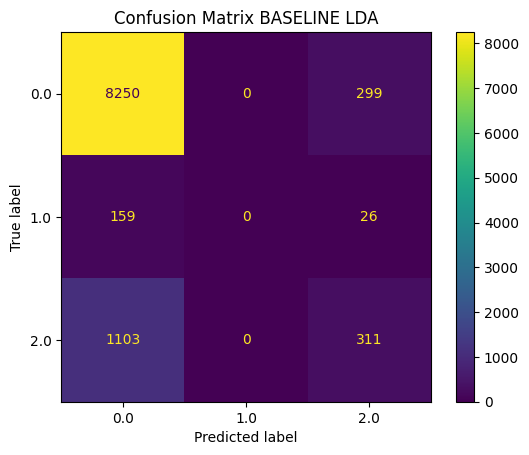

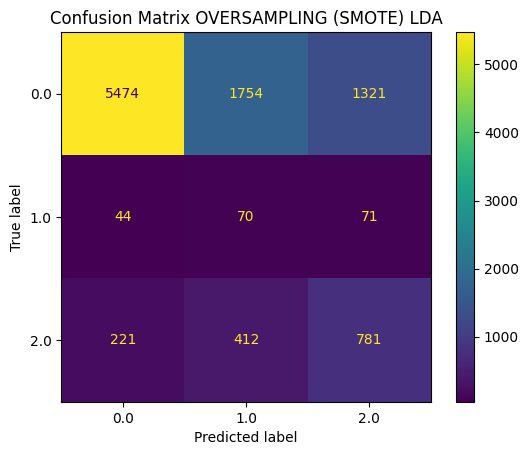

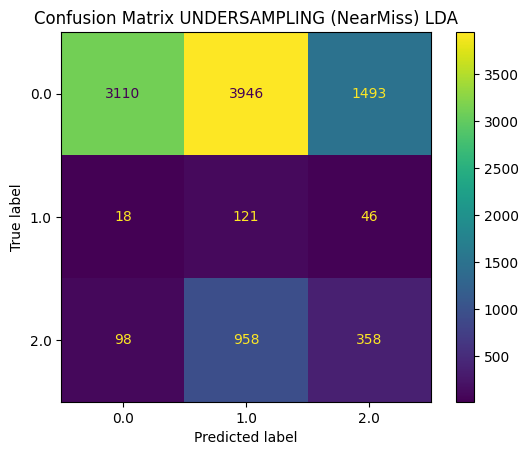

In [ ]:
#baseline model
y_pred_baseline = model_lda_baseline.predict(X_test)
conf_matrix_baseline = confusion_matrix(y_test, y_pred_baseline)
disp_baseline = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_baseline, display_labels=model_lda_baseline.classes_)
disp_baseline.plot()
plt.title("Confusion Matrix BASELINE LDA")

#oversampled SMOTE model
y_pred_smote = model_lda_smote.predict(X_test)
conf_matrix_smote = confusion_matrix(y_test, y_pred_smote)
disp_smote = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_smote, display_labels=model_lda_smote.classes_)
disp_smote.plot()
plt.title("Confusion Matrix OVERSAMPLING (SMOTE) LDA")

#undersampled NEARMISS LDA
y_pred_nm = model_lda_nm.predict(X_test)
conf_matrix_nm = confusion_matrix(y_test, y_pred_nm)
disp_nm = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_nm, display_labels=model_lda_nm.classes_)
disp_nm.plot()
plt.title("Confusion Matrix UNDERSAMPLING (NearMiss) LDA")

In [ ]:
print("Classification Report (Baseline)")
print(classification_report(y_test, y_pred_baseline))
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
print(f"Accuracy baseline: {accuracy_baseline:.4f}")



print("Classification Report Oversampling (SMOTE)")
print(classification_report(y_test, y_pred_smote))
accuracy_smote = accuracy_score(y_test, y_pred_smote)
print(f"Accuracy oversampling (SMOTE): {accuracy_smote:.4f}")



print("Classification Report Undersampling (NearMiss)")
print(classification_report(y_test, y_pred_nm))
accuracy_nm = accuracy_score(y_test, y_pred_nm)
print(f"Accuracy undersampling (NearMiss): {accuracy_nm:.4f}")

Classification Report (Baseline)
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.91      8549
         1.0       0.00      0.00      0.00       185
         2.0       0.49      0.22      0.30      1414

    accuracy                           0.84     10148
   macro avg       0.45      0.39      0.41     10148
weighted avg       0.80      0.84      0.81     10148

Accuracy baseline: 0.8436
Classification Report Oversampling (SMOTE)
              precision    recall  f1-score   support

         0.0       0.95      0.64      0.77      8549
         1.0       0.03      0.38      0.06       185
         2.0       0.36      0.55      0.44      1414

    accuracy                           0.62     10148
   macro avg       0.45      0.52      0.42     10148
weighted avg       0.85      0.62      0.71     10148

Accuracy oversampling (SMOTE): 0.6233
Classification Report Undersampling (NearMiss)
              precision    recall  f1-score   suppo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Cart

### Pre Processing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error



train = pd.read_csv('/content/train_binary.csv')
test = pd.read_csv('/content/test_binary.csv')

X_train= pd.get_dummies(train.drop(['has_diabetes'], axis=1))
y_train= train['has_diabetes']

X_test= pd.get_dummies(test.drop(['has_diabetes'], axis=1))
y_test= test['has_diabetes']

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# Near Miss
nm = NearMiss()
X_train_undersampled, y_train_undersampled = nm.fit_resample(X_train, y_train)

# Oversampling with SMOTE
smote = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

# Logging
print("Before doint anything:", y_train.value_counts())
print("After undersampling:", pd.Series(y_train_undersampled).value_counts())
print("After oversampling:", pd.Series(y_train_oversampled).value_counts())

Before doint anything: has_diabetes
0.0    205155
1.0     33932
Name: count, dtype: int64
After undersampling: has_diabetes
0.0    33932
1.0    33932
Name: count, dtype: int64
After oversampling: has_diabetes
1.0    205155
0.0    205155
Name: count, dtype: int64


### Training

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

grid_values = {
    'ccp_alpha': [0.0005],
    'min_samples_leaf': [5],
    'min_samples_split': [30],
    'max_depth': [10],
    'random_state': [88]
}



dtc = DecisionTreeClassifier()
dtc_cv_undersampling = GridSearchCV(dtc, param_grid = grid_values, scoring = 'accuracy', cv=5, verbose=1)
dtc_cv_undersampling.fit(X_train_undersampled, y_train_undersampled)

y_pred_undersampling = dtc_cv_undersampling.best_estimator_.predict(X_test)

dtc_cv_oversampling = GridSearchCV(dtc, param_grid = grid_values, scoring = 'accuracy', cv=5, verbose=1)
dtc_cv_oversampling.fit(X_train_oversampled, y_train_oversampled)

y_pred_oversampling = dtc_cv_oversampling.best_estimator_.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


### Evaluation

Text(0.5, 1.0, 'Confusion Matrix OVERSAMPLING Gradient CART Classifier')

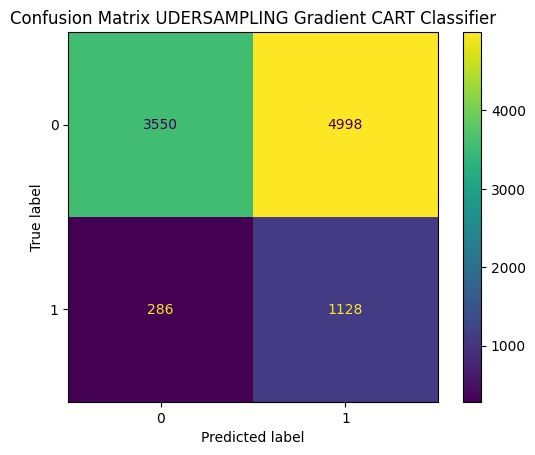

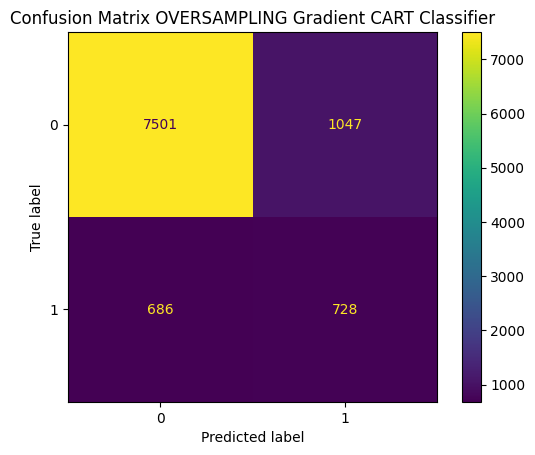

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score

cm_undersampling = confusion_matrix(y_test, y_pred_undersampling)
disp_undersampling = ConfusionMatrixDisplay(confusion_matrix=cm_undersampling)
disp_undersampling.plot()
plt.title("Confusion Matrix UDERSAMPLING Gradient CART Classifier")


cm_oversampling = confusion_matrix(y_test, y_pred_oversampling)
disp_oversampling = ConfusionMatrixDisplay(confusion_matrix=cm_oversampling)
disp_oversampling.plot()
plt.title("Confusion Matrix OVERSAMPLING Gradient CART Classifier")

In [ ]:

print("Classification Report Undersampling (NearMiss)")
print(classification_report(y_test, y_pred_undersampling))
accuracy_undersampling = accuracy_score(y_test, y_pred_undersampling)
print(f"Accuracy undersampling (NearMiss): {accuracy_undersampling:.4f}\n")


print("Classification Report Oversampling (SMOTE)")
print(classification_report(y_test, y_pred_oversampling))
accuracy_oversampling = accuracy_score(y_test, y_pred_oversampling)
print(f"Accuracy oversampling (SMOTE): {accuracy_oversampling:.4f}\n")


Classification Report Undersampling (NearMiss)
              precision    recall  f1-score   support

         0.0       0.93      0.42      0.57      8548
         1.0       0.18      0.80      0.30      1414

    accuracy                           0.47      9962
   macro avg       0.55      0.61      0.44      9962
weighted avg       0.82      0.47      0.53      9962

Accuracy undersampling (NearMiss): 0.4696

Classification Report Oversampling (SMOTE)
              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90      8548
         1.0       0.41      0.51      0.46      1414

    accuracy                           0.83      9962
   macro avg       0.66      0.70      0.68      9962
weighted avg       0.84      0.83      0.83      9962

Accuracy oversampling (SMOTE): 0.8260



## Random Forest

### Pre Processing

In [ ]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


tic = time.time()

train = pd.read_csv('/content/train_multiclass.csv')
test = pd.read_csv('/content/test_multiclass.csv')

X_train= train.drop('diabetes_type', axis=1)
y_train= train['diabetes_type']

X_test= test.drop('diabetes_type', axis=1)
y_test= test['diabetes_type']


# Near Miss
nm = NearMiss()
X_train_undersampled, y_train_undersampled = nm.fit_resample(X_train, y_train)

# Oversampling with SMOTE
smote = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

# Logging
print("Before doint anything:", y_train.value_counts())
print("After undersampling:", pd.Series(y_train_undersampled).value_counts())
print("After oversampling:", pd.Series(y_train_oversampled).value_counts())

Before doint anything: diabetes_type
0.0    205154
2.0     33932
1.0      4446
Name: count, dtype: int64
After undersampling: diabetes_type
0.0    4446
1.0    4446
2.0    4446
Name: count, dtype: int64
After oversampling: diabetes_type
0.0    205154
2.0    205154
1.0    205154
Name: count, dtype: int64


### Training

In [ ]:
rf_oversampling = RandomForestClassifier(max_features=len(X_train_oversampled.columns), random_state=2024)
rf_oversampling.fit(X_train_oversampled, y_train_oversampled)
y_pred_oversampling = rf_oversampling.predict(X_test)

rf_undersampling = RandomForestClassifier(max_features=len(X_train_undersampled.columns), random_state=2024)
rf_undersampling.fit(X_train_undersampled, y_train_undersampled)
y_pred_undersampling = rf_undersampling.predict(X_test)


toc = time.time()

print('time:', round(toc-tic, 2),'s')

Random Forest Test Accuracy: 0.8495
time: 460.85 s


### Evaluation


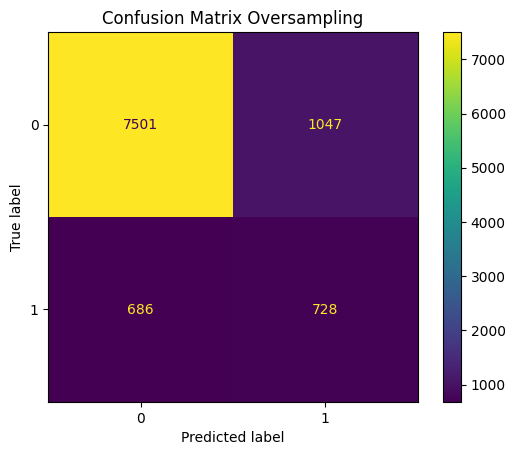

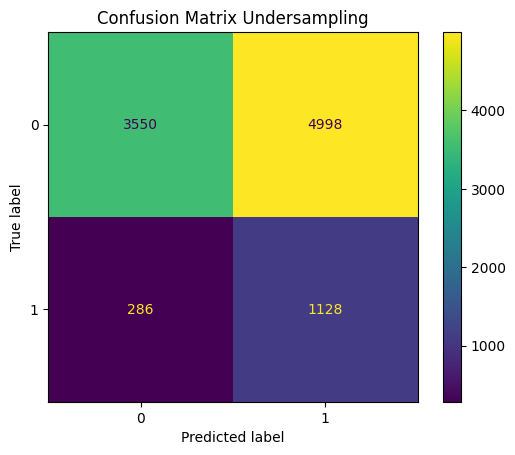

In [ ]:

conf_matrix_oversampling = confusion_matrix(y_test, y_pred_oversampling)
disp_oversampling = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_oversampling)
disp_oversampling.plot()
plt.title("Confusion Matrix Oversampling")

# For oversampling

conf_matrix_undersampling = confusion_matrix(y_test, y_pred_undersampling)
disp_undersampling = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_undersampling)
disp_undersampling.plot()
plt.title("Confusion Matrix Undersampling")

plt.show()

In [ ]:
print("Classification Report Oversampling (Random Forest)")
print(classification_report(y_test, y_pred_oversampling))
accuracy_oversampling = accuracy_score(y_test, y_pred_oversampling)
print(f"Accuracy oversampling (Random Forest): {accuracy_oversampling:.4f}\n")

print("Classification Report Undersampling (Random Forest)")
print(classification_report(y_test, y_pred_undersampling))
accuracy_undersampling = accuracy_score(y_test, y_pred_undersampling)
print(f"Accuracy undersampling (Random Forest): {accuracy_undersampling:.4f}\n")


Classification Report Oversampling (Random Forest)
              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90      8548
         1.0       0.41      0.51      0.46      1414

    accuracy                           0.83      9962
   macro avg       0.66      0.70      0.68      9962
weighted avg       0.84      0.83      0.83      9962

Accuracy oversampling (Random Forest): 0.8260

Classification Report Undersampling (Random Forest)
              precision    recall  f1-score   support

         0.0       0.93      0.42      0.57      8548
         1.0       0.18      0.80      0.30      1414

    accuracy                           0.47      9962
   macro avg       0.55      0.61      0.44      9962
weighted avg       0.82      0.47      0.53      9962

Accuracy undersampling (Random Forest): 0.4696



## Multi Class PyTorch NN

Used resource: https://machinelearningmastery.com/introduction-to-softmax-classifier-in-pytorch/

### Pre Processing

In [ ]:
train = pd.read_csv('/content/train_multiclass.csv')
test = pd.read_csv('/content/test_multiclass.csv')

X_train= train.drop('diabetes_type', axis=1)
y_train= train['diabetes_type']

X_test= test.drop('diabetes_type', axis=1)
y_test= test['diabetes_type']


# Oversampling with SMOTE
smote = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

# Logging
print("Before doint anything:", y_train.value_counts())
print("After oversampling:", pd.Series(y_train_oversampled).value_counts())


Before doint anything: diabetes_type
0.0    205154
2.0     33932
1.0      4446
Name: count, dtype: int64
After oversampling: diabetes_type
0.0    205154
2.0    205154
1.0    205154
Name: count, dtype: int64


In [ ]:
# Torch needs the input data to be formatted as Tensors and putted in a DataLoader
X = torch.tensor(X_train_oversampled.to_numpy(), dtype=torch.float32)
y = torch.tensor(y_train_oversampled.to_numpy(), dtype=torch.int).long()

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


### Training

In [ ]:
# This time more hidden layers because we wanted to get a more complicated model

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(21, 180)  # 21 features, 180 neurons
        self.relu1 = nn.ReLU()

        # Second hidden layer
        self.hidden2 = nn.Linear(180, 90)  # 180 neurons -> 90 neurons
        self.relu2 = nn.ReLU()

        # Third hidden layer
        self.hidden3 = nn.Linear(90, 90)  # 90 neurons -> 90 neurons
        self.relu3 = nn.ReLU()

        # Fourth hidden layer
        self.hidden4 = nn.Linear(90, 20)  # 90 neurons -> 20 neurons
        self.relu4 = nn.ReLU()

        # Output layer
        self.output = nn.Linear(20, 3)  # 3 output neurons (for 3 classes) - not activated because CrossEntropyLoss

    def forward(self, x):
        x = self.relu1(self.hidden1(x))
        x = self.relu2(self.hidden2(x))
        x = self.relu3(self.hidden3(x))
        x = self.relu4(self.hidden4(x))
        x = self.output(x)
        return x


In [ ]:
model = Model()

criterion = nn.CrossEntropyLoss()  # Multi-class Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 15  # After 15 epochs we see a convergence of the loss
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()

        total_loss = total_loss+ loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")

Epoch 1/15, Loss: 17181.5147
Epoch 2/15, Loss: 14448.8039
Epoch 3/15, Loss: 13436.9947
Epoch 4/15, Loss: 12755.4299
Epoch 5/15, Loss: 12209.5999
Epoch 6/15, Loss: 11821.0813
Epoch 7/15, Loss: 11512.9942
Epoch 8/15, Loss: 11236.3454
Epoch 9/15, Loss: 10987.8950
Epoch 10/15, Loss: 10799.2482
Epoch 11/15, Loss: 10621.7234
Epoch 12/15, Loss: 10462.9198
Epoch 13/15, Loss: 10316.5786
Epoch 14/15, Loss: 10181.9806
Epoch 15/15, Loss: 10052.2169


### Evaluation

In [ ]:
model.eval() # Turn into evaluation mode

# Convert X_test to a tensor (similar to X_Train)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)


with torch.no_grad():  # Disable gradient calculations
    predictions = model(X_test_tensor)


predicted_classes = torch.argmax(predictions, dim=1)

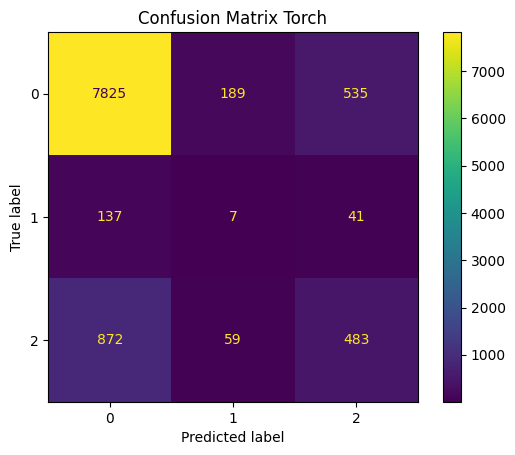

In [ ]:
# Confusion Matrix
conf_matrix_torch = confusion_matrix(y_test, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_torch, display_labels=[0,1,2])
disp.plot()
plt.title("Confusion Matrix Torch")

plt.show()

In [ ]:

print("Classification Report Pytorch")
print(classification_report(y_test, predicted_classes))


accuracy_pytorch = accuracy_score(y_test, predicted_classes)
print(f"\n\nAccuracy pytorch: {accuracy_pytorch:.4f}")



Classification Report Pytorch
              precision    recall  f1-score   support

         0.0       0.89      0.92      0.90      8549
         1.0       0.03      0.04      0.03       185
         2.0       0.46      0.34      0.39      1414

    accuracy                           0.82     10148
   macro avg       0.46      0.43      0.44     10148
weighted avg       0.81      0.82      0.81     10148



Accuracy pytorch: 0.8194


# Multi Class Comparison Table¶

In [ ]:
import pandas as pd

# Data for the models
data = {
    'Model': [
        'Baseline Model',
        'LDA (Original)',
        'LDA (Oversampling)',
        'LDA (Undersampling)',
        'CART (Oversampling)',
        'CART (Undersampling)',
        'Gradient Boosting (Oversampling)',
        'Gradient Boosting (Undersampling)',
        'Random Forest (Oversampling)',
        'Random Forest (Undersampling)',
        'Torch',
    ],
    'Metrics': [
        {'Precision': 0.45, 'Recall': 0.39, 'F1-Score': 0.41, 'Support': 10148},  # Baseline
        {'Precision': 0.49, 'Recall': 0.41, 'F1-Score': 0.41, 'Support': 10148},  # LDA (Original)
        {'Precision': 0.45, 'Recall': 0.52, 'F1-Score': 0.42, 'Support': 10148},  # LDA (Oversampling)
        {'Precision': 0.39, 'Recall': 0.42, 'F1-Score': 0.26, 'Support': 10148},  # LDA (Undersampling)
        {'Precision': 0.66, 'Recall': 0.70, 'F1-Score': 0.68, 'Support': 9962},   # CART (Oversampling)
        {'Precision': 0.55, 'Recall': 0.61, 'F1-Score': 0.44, 'Support': 9962},   # CART (Undersampling)
        {'Precision': 0.46, 'Recall': 0.46, 'F1-Score': 0.38, 'Support': 10148},  # Gradient Boosting (Oversampling)
        {'Precision': 0.38, 'Recall': 0.37, 'F1-Score': 0.26, 'Support': 10148},  # Gradient Boosting (Undersampling)
        {'Precision': 0.66, 'Recall': 0.70, 'F1-Score': 0.68, 'Support': 9962},   # Random Forest (Oversampling)
        {'Precision': 0.55, 'Recall': 0.61, 'F1-Score': 0.44, 'Support': 9962},   # Random Forest (Undersampling)
        {'Precision': 0.46, 'Recall': 0.43, 'F1-Score': 0.44, 'Support': 10148},  # Torch
    ]
}

# Create DataFrame
results_df = pd.DataFrame(data)

# Expand Metrics column into separate columns
metrics_df = results_df['Metrics'].apply(pd.Series)
final_df = pd.concat([results_df['Model'], metrics_df], axis=1)

# Display the dataframe
final_df


,Model,Precision,Recall,F1-Score,Support
0,Baseline Model,0.45,0.39,0.41,10148.0
1,LDA (Original),0.49,0.41,0.41,10148.0
2,LDA (Oversampling),0.45,0.52,0.42,10148.0
3,LDA (Undersampling),0.39,0.42,0.26,10148.0
4,CART (Oversampling),0.66,0.70,0.68,9962.0
5,CART (Undersampling),0.55,0.61,0.44,9962.0
6,Gradient Boosting (Oversampling),0.46,0.46,0.38,10148.0
7,Gradient Boosting (Undersampling),0.38,0.37,0.26,10148.0
8,Random Forest (Oversampling),0.66,0.70,0.68,9962.0
9,Random Forest (Undersampling),0.55,0.61,0.44,9962.0


In [ ]:
import pandas as pd

# Data for the models
data = {
    'Model': [
        'Baseline Model',
        'LDA (Original)',
        'LDA (Oversampling)',
        'LDA (Undersampling)',
        'CART (Oversampling)',
        'CART (Undersampling)',
        'Gradient Boosting (Oversampling)',
        'Gradient Boosting (Undersampling)',
        'Random Forest (Oversampling)',
        'Random Forest (Undersampling)',
        'Torch'
    ],
    'Performance Summary': [
        'Baseline model with low performance',
        'Slight improvement',
        'Better recall, moderate precision',
        'Poor performance with low F1-Score',
        'Best overall performance',
        'Lower than oversampling',
        'Moderate performance, low F1-Score',
        'Low performance with undersampling',
        'Nice performance',
        'Lower than oversampling',
        'Moderate performance'
    ],
    'Interpretability': [
        'High',
        'High',
        'High',
        'High',
        'High',
        'High',
        'Moderate',
        'Moderate',
        'High',
        'High',
        'Low'
    ]
}

# Create DataFrame
final_df = pd.DataFrame(data)

# Display the dataframe in a styled table
styled_table = final_df.style.set_table_styles([
    {'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('font-size', '12pt'), ('text-align', 'left')]}
]).set_properties(**{
    'text-align': 'left',
    'padding': '10px'
}).set_caption("Comparison of Model Performance and Interpretability")

# Display the styled table
styled_table

,Model,Performance Summary,Interpretability
0,Baseline Model,Baseline model with low performance,High
1,LDA (Original),Slight improvement,High
2,LDA (Oversampling),"Better recall, moderate precision",High
3,LDA (Undersampling),Poor performance with low F1-Score,High
4,CART (Oversampling),Best overall performance,High
5,CART (Undersampling),Lower than oversampling,High
6,Gradient Boosting (Oversampling),"Moderate performance, low F1-Score",Moderate
7,Gradient Boosting (Undersampling),Low performance with undersampling,Moderate
8,Random Forest (Oversampling),Nice performance,High
9,Random Forest (Undersampling),Lower than oversampling,High
